# In this notebook:
1. Model simulations and paper's figuers


# Importing

In [1]:
path_dir = "pycharm"
import os
os.chdir(path_dir)
import TAMU_model as model
os.chdir('../')
import numpy as np
import pandas as pd
from matplotlib.patches import Patch
import itertools
import pickle
from matplotlib import pyplot as plt
import datetime
from importlib import reload
from scipy import optimize
from matplotlib.ticker import FuncFormatter
from matplotlib.pyplot import text
plt.style.use('dean_style.conf')
fig_loc = './new_draft/figures/{}.png'
from seaborn import regplot, color_palette
_pallete = color_palette()
import seaborn as sns
from matplotlib.colors import ListedColormap
# activate latex text rendering

## Reload model

In [2]:
os.chdir(path_dir)
model = reload(model)
os.chdir('../')

# Gray Colormap

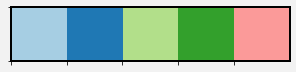

In [3]:
# palette for age group dist.
flatui = ["#a6cee3", "#1f78b4", "#b2df8a", "#33a02c", "#fb9a99"]
sns.palplot(sns.color_palette(flatui))

In [4]:
sns.color_palette(flatui)

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6)]

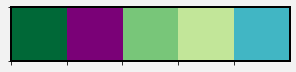

In [5]:
flatui2 = ["#006837", "#7a0177", "#78c679", "#c2e699", "#41b6c4"]
sns.palplot(sns.color_palette(flatui2))

In [6]:
newcmp = ListedColormap(flatui)
newcmp2 = ListedColormap(flatui2)

In [7]:
from matplotlib.colors import LinearSegmentedColormap

def grayscale_cmap(cmap):
    """Return a grayscale version of the given colormap"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    
    # convert RGBA to perceived grayscale luminance
    # cf. http://alienryderflex.com/hsp.html
#     RGB_weight = [0.299, 0.587, 0.114]
    RGB_weight = _pallete[2]
    luminance = np.sqrt(np.dot(colors[:, :3] ** 2, RGB_weight))
    colors[:, :3] = luminance[:, np.newaxis]
        
    return LinearSegmentedColormap.from_list(cmap.name + "_gray", colors, cmap.N)
    

def view_colormap(cmap):
    """Plot a colormap with its grayscale equivalent"""
    cmap = plt.cm.get_cmap(cmap)
    colors = cmap(np.arange(cmap.N))
    
    cmap = grayscale_cmap(cmap)
    grayscale = cmap(np.arange(cmap.N))
    
    fig, ax = plt.subplots(2, figsize=(6, 2),
                           subplot_kw=dict(xticks=[], yticks=[]))
    ax[0].imshow([colors], extent=[0, 10, 0, 1])
    ax[1].imshow([grayscale], extent=[0, 10, 0, 1])

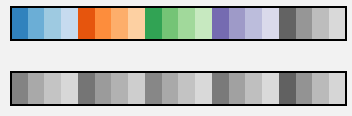

In [8]:
view_colormap('tab20c')
tab20c_gray = grayscale_cmap('tab20c')

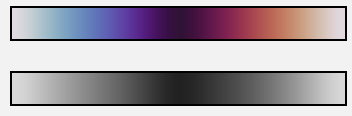

In [9]:
view_colormap('twilight')
twilight_gray = grayscale_cmap('twilight')

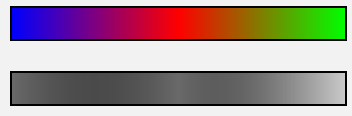

In [10]:
view_colormap('brg')
brg_gray = grayscale_cmap('brg')

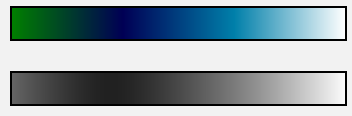

In [11]:
view_colormap('ocean')
ocean_gray = grayscale_cmap('ocean')

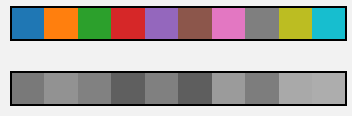

In [12]:
view_colormap('tab10')
tab10_gray = grayscale_cmap('tab10')

# Plot Functions

In [19]:
font = {
        'weight' : 'bold',
        'size'   : 26}

plt.rc('font', **font)

In [20]:
def plot_calibration(calibrate_mdl, state_data, state, population, ylim_max, panel=None, fntsize=None, jump=100000):
    """The function plots the fitted model relative to data points"""
    plt.style.use('dean_style.conf')
    fig = plt.figure()
    
    ax = plt.subplot(111)
    
    # plotting data points
    ax.scatter(calibrate_mdl.index,state_data['total'] * population, label='Data', color = '#012C61',s=4, zorder=2)
    
    # plotting model
    ax.plot(calibrate_mdl.index,calibrate_mdl['total'] * population, label='Model', color = '#FFB700',
             linewidth=2.5,zorder=1)
    # removes frames
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    

    ax.legend(frameon=False, prop={'weight':'bold'})
    ax.set_title(state,fontweight='bold')
    ax.set_ylabel('Weekly Influenza cases',fontweight='bold')
    ax.set_xlabel('Season',fontweight='bold')
    ax.set_yticks([i for i in range(0,ylim_max + jump, jump)])
    ax.set_xlim((735465,737358.00000411))
    ax.set_ylim((0,ylim_max))
    ax.set_yticklabels([0]+[thousands(tick) for tick in ax.get_yticks()[1:]],fontweight='bold')
    ax.text(-0.13,1.0, panel, horizontalalignment='left', transform=ax.transAxes,fontsize=25, fontweight='bold')

    plt.rcParams["font.weight"] = "bold"
    plt.show()
    plt.close()
    return fig,ax
    calibrate_mdl['total'].to_csv('fig1 {}.csv'.format(state))
    
def plot_calibration_age_group(proportion_mdl, proportion_dt, state, panel=None, fntsize=None):
    """The function plots bar of the proportion of cases for each age group, model vs data"""
    # calculate the mean:
    mdl_mean_proportion = proportion_mdl.mean()
    data_mean_proportion = proportion_dt.mean()
    
    # set width of bar
    barWidth = 0.25

    # set height of bar
    bars1 = [mdl_mean_proportion[model.A[i]] for i in range(5)]
    bars2 = [data_mean_proportion[model.A[i]] for i in range(5)]

    # Set position of bar on X axis
    r1 = np.arange(len(bars1))
    r2 = [x + barWidth for x in r1]

    # Make the plot
    plt.style.use('dean_style.conf')
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.bar(r1, bars1, color='#FFB700', width=barWidth, edgecolor='white', label='Model')
    ax.bar(r2, bars2, color='#012C61', width=barWidth, edgecolor='white', label='Data')
    
    # removes frames
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # Add xticks + yticks on the middle of the group bars
    ax.set_xlabel('Age Group',fontweight='bold')
    ax.set_xticks([r + barWidth * 0.5 for r in range(len(bars1))])
    ax.set_xticklabels(['0-4y', '5-19y', '20-49y', '50-64y', '65+y'],fontweight='bold')
    ax.set_ylabel('Proportion of Influenza cases', fontweight='bold')
    ax.set_ylim(0,0.5)
    ax.set_yticks([0.1,0.2,0.3,0.4, 0.5])

    # Create legend & Show graphic
    ax.text(-0.10,1.0, panel, horizontalalignment='left', transform=ax.transAxes, fontsize=25, fontweight='bold')
    ax.legend(frameon=False, prop={'weight':'bold'})
    ax.set_title(state,fontweight='bold')
    plt.rcParams["font.weight"] = "bold"
    plt.show()
    plt.close()
    return fig,ax
    
#     print(bars1)
    
    
def thousands(x):
    'The two args are the value and tick position'
    if int(str(x)[-1]) == 0:
        return '%1.0fK' % (float(x)*1e-3)
    return '%1.2fK' % (float(x)*1e-3)


def shifting_tratments_plots(fitted_params,  state, population, ylim_max_cases,
                            xlim_max_cases, ylim_max_hosp, xlim_max_hosp,title = None, panel=[None,None], fntsize=None,
                            jump=15000,jump_hosp=150):
    """This function gets state parameters, calculates and plots the number of cases (hospitalization) averted by
    shifting individuals to get treated on the 2nd day. while keeping the proportion of treated as the in baseline
    (Figure 2)"""
    
    results = {}
    for vacc_incerease in [0.8,0.9,1,1.1,1.2]:
    
        # baseline with state vacc coverage
        results[vacc_incerease] = model.shifting_treated_within_2d(state, range(2015,2020), fitted_params,
                                                             np.minimum(model.vaccination_coverage[state] * vacc_incerease, 1.0))

    cases_lst_to_df = []
    hosp_lst_to_df = []
    for key in results: 
    # cases averted for mean line
        temp_df = results[key]['Cases']
        temp_df['averted'] = (temp_df.baseline_cases - temp_df.new_policy_cases)
        # calculating the mean scenario for each 5 seasons
        temp_df['vacc_coverage'] = key
        temp_df['percentage_change'] = temp_df['percentage_change'] * 100
        cases_lst_to_df.append(temp_df)
    
    # hospitalizations averted for mean line  
        hosp_temp = results[key]['Hospital']
        hosp_temp['averted'] = (hosp_temp.baseline_hospital - hosp_temp.new_policy_hospital)
        # calculating the mean scenario for each 5 seasons
        hosp_temp['vacc_coverage'] = key
        hosp_temp['percentage_change'] = hosp_temp['percentage_change'] * 100
        hosp_lst_to_df.append(hosp_temp)
    
    


    # coverting to df 
    cases_df = pd.concat(cases_lst_to_df)
    hosp_df = pd.concat(hosp_lst_to_df)
    
    cases_df = cases_df.groupby(['percentage_change', 'vacc_coverage']).mean()
    hosp_df = hosp_df.groupby(['percentage_change', 'vacc_coverage']).mean()
    cases_df['averted number'] = cases_df['averted'] * population
    hosp_df['averted number'] = hosp_df['averted'] * population


       # Plot cases    
    # rename index
    plt.style.use('dean_style.conf')
    fig_cases = plt.figure()
    cases_df.index.names = ['Precetage Treated','Vaccination Coverage']
    cases_df.rename(index={0.8:'-20%', 0.9:'-10%', 1:'Baseline', 1.1:'+10%', 1.2:'+20%'}, 
                                      level='Vaccination Coverage', inplace=True)
    
    ax_cases = plt.subplot(111)
    (cases_df.unstack()['averted number'][['+20%','+10%','Baseline','-10%','-20%']]).plot(style=['-.','-.','-','--','--'],
                                                                                    color=['#a1d99b','#31a354','#00441b','#31a354','#a1d99b'],
                                                                                    alpha=0.8, ax=ax_cases)
    
    # removes frames
    ax_cases.spines['right'].set_visible(False)
    ax_cases.spines['top'].set_visible(False)
        
    ax_cases.set_ylim((0,ylim_max_cases))
    ax_cases.set_xlim((0,100))
    ax_cases.set_title(title, fontweight="bold")
    ax_cases.legend(title='Effective vaccination coverage',frameon=False, prop={'weight':'bold'})
    ax_cases.set_xlabel("Percentage of late-treated patients\n who received treatment within 48 hours (%)", fontweight='bold')
    ax_cases.set_ylabel('Additional influenza\n cases averted annually', fontweight='bold')
    ax_cases.set_yticks(range(0,ylim_max_cases + jump,jump))
    ax_cases.set_yticklabels([0] + [thousands(tick) for tick in ax_cases.get_yticks()[1:]])
    ax_cases.text(-0.15,1.0, panel[0], horizontalalignment='left', transform=ax_cases.transAxes, fontsize=25, fontweight='bold')
    plt.rcParams["font.weight"] = "bold"
    plt.show()
    plt.close()
    
    
    # Plot hospitalizations  
    # rename index
    fig_hosp = plt.figure()
    hosp_df.index.names = ['Precetage Treated','Vaccination Coverage']
    hosp_df.rename(index={0.8:'-20%', 0.9:'-10%', 1:'Baseline', 1.1:'+10%', 1.2:'+20%'}, 
                                      level='Vaccination Coverage', inplace=True)
    ax_hosp = plt.subplot(111)
    (hosp_df.unstack()['averted number'][['+20%','+10%','Baseline','-10%','-20%']]).plot(style=['-.','-.','-','--','--'],
                                                                               color=['#a1d99b','#31a354','#00441b','#31a354','#a1d99b'],
                                                                                alpha=0.8,ax=ax_hosp)
    # removes frames
    ax_hosp.spines['right'].set_visible(False)
    ax_hosp.spines['top'].set_visible(False)
    
    ax_hosp.set_ylim((0,ylim_max_hosp))
    ax_hosp.set_xlim((0,100))
    ax_hosp.set_title(title, fontweight="bold")
    ax_hosp.legend(title='Effective vaccination coverage',frameon=False, prop={'weight':'bold'})
    ax_hosp.set_xlabel("Percentage of late-treated patients\n who received treatment within 48 hours (%)", fontweight='bold')
    ax_hosp.set_ylabel("Additional hospitalizations\naverted annually", fontweight='bold')
    ax_hosp.set_yticks(range(0,ylim_max_hosp +jump_hosp,jump_hosp))
    ax_hosp.text(-0.15,1.0, panel[1], horizontalalignment='left', transform=ax_hosp.transAxes, fontsize=25, fontweight='bold')

    plt.rcParams["font.weight"] = "bold"
    plt.show()
    plt.close()
    
#     # save data per treatment as csv
    cases_df['per treatment'] = cases_df.averted / (cases_df.shifted * cases_df['baseline_cases'])
    
    
    hosp_df['per treatment'] = hosp_df.averted / (hosp_df.shifted * hosp_df['baseline_hospital'])
   

     # save  cases:
    cases_df.to_csv('fig2 per treatment case  {}.csv'.format(state))

#     # save  hospital:
    hosp_df.to_csv('fig2 per treatment hosp  {}.csv'.format(state))

    
    return fig_cases,ax_cases,fig_hosp,ax_hosp

def increase_treatment_plots(fitted_params, state, population, ylim_max_cases= None,
                            xlim_max_cases= None, ylim_max_hosp= None, xlim_max_hosp= None, title=None, panel=[None,None],
                             fntsize=None, jump=50000, jump_hosp=500):
    """ This function gets state parrameters and pruduces plots of averted cases (hospitalization) for each
    vaccination coverage increase and treatment coverage"""
    
    # Calsulates baseline cases
    baseline = {}
    for vacc_incerease in [0.8,0.9,1,1.1,1.2]:
        baseline[vacc_incerease] = model.get_baseline_results_age_group(state, range(2015,2020), fitted_params,
                                                   np.minimum(model.vaccination_coverage[state] * vacc_incerease, 1.0))
    # Calculates cases with new treatment precentage
    treatment_increase = np.arange(0.1,0.31,0.01)
    increase_within_2d_res = model.increase_treated(state, range(2015,2020),
                                                fitted_params,treatment_increase, model.vaccination_coverage[state],
                                               baseline)
    
    # ---- Cases ---- #
    # Averted cases
    increse_2days = increase_within_2d_res['Cases']
    increse_2days['averted'] = increse_2days.baseline_cases - increse_2days.new_policy_cases
    
    # Averted cases in terms of population size
    increse_2days['averted'] = (increse_2days.apply(lambda x: 0 if x.percentage_increase == 0 else x.averted, axis=1)) *\
                                population
    
    # Average over the years
    increse_2days_avg = increse_2days.groupby(['percentage_increase', 'vacc_coverage']).mean()
    increse_2days_avg_cases = increse_2days_avg['averted'].copy()
    
    # Plot cases    
    # rename index
    plt.style.use('dean_style.conf')
    fig_cases = plt.figure()
    increse_2days_avg_cases.index.names = ['Precetage Treated','Vaccination Coverage']
    increse_2days_avg_cases.rename(index={0.8:'-20%', 0.9:'-10%', 1:'Baseline', 1.1:'+10%', 1.2:'+20%'}, 
                                      level='Vaccination Coverage', inplace=True)
    ax_cases = plt.subplot(111)
    (increse_2days_avg_cases.unstack()[['+20%','+10%','Baseline','-10%','-20%']]).plot(style=['-.','-.','-','--','--'],
                                                                                    color=['#a1d99b','#31a354','#00441b','#31a354','#a1d99b'],
                                                                                    alpha=0.8, ax=ax_cases)
    
    # removes frames
    ax_cases.spines['right'].set_visible(False)
    ax_cases.spines['top'].set_visible(False)
        
    ax_cases.set_ylim((0,ylim_max_cases))
    ax_cases.set_xlim((0.099,0.3))
    ax_cases.set_title(title, fontweight="bold")
    ax_cases.legend(title='Effective vaccination coverage',frameon=False, prop={'weight':'bold'})
    ax_cases.set_xlabel("Proportion of treated high-risk individuals", fontweight='bold')
    ax_cases.set_ylabel("Additional cases averted annually", fontweight='bold')
    ax_cases.set_yticks(range(0,ylim_max_cases + jump,jump))
    ax_cases.set_yticklabels([0] + [thousands(tick) for tick in ax_cases.get_yticks()[1:]])
    ax_cases.text(-0.15,1.0, panel[0], horizontalalignment='left', transform=ax_cases.transAxes, fontsize=25, fontweight='bold')
    plt.rcParams["font.weight"] = "bold"
    plt.show()
    plt.close()
    
    # ---- Hospitalizations ---- #
    plt.style.use('dean_style.conf')
    fig_hosp = plt.figure()
    # Averted hospitalizations
    increse_2days_hosp = increase_within_2d_res['Hospital']
    increse_2days_hosp['averted'] = increse_2days_hosp.baseline_hospital - increse_2days_hosp.new_policy_hospital
    
    # Averted hospitalizations in terms of population size
    increse_2days_hosp['averted'] = (increse_2days_hosp.apply(lambda x: 0 if x.percentage_increase == 0 else x.averted,
                                                                axis=1)) * population
    
    # Average over the years   
    increse_2days_avg_hosp = increse_2days_hosp.groupby(['percentage_increase', 'vacc_coverage']).mean()
    increse_2days_avg_averted_hosp = increse_2days_avg_hosp['averted'].copy()
    
    # Plot hospitalizations  
    # rename index
    increse_2days_avg_averted_hosp.index.names = ['Precetage Treated','Vaccination Coverage']
    increse_2days_avg_averted_hosp.rename(index={0.8:'-20%', 0.9:'-10%', 1:'Baseline', 1.1:'+10%', 1.2:'+20%'}, 
                                      level='Vaccination Coverage', inplace=True)
    ax_hosp = plt.subplot(111)
    (increse_2days_avg_averted_hosp.unstack()[['+20%','+10%','Baseline','-10%','-20%']]).plot(style=['-.','-.','-','--','--'],
                                                                               color=['#a1d99b','#31a354','#00441b','#31a354','#a1d99b'],
                                                                                alpha=0.8,ax=ax_hosp)
    # removes frames
    ax_hosp.spines['right'].set_visible(False)
    ax_hosp.spines['top'].set_visible(False)
    
    ax_hosp.set_ylim((0,ylim_max_hosp))
    ax_hosp.set_xlim((0.099,0.3))
    ax_hosp.set_title(title, fontweight="bold")
    ax_hosp.legend(title='Effective vaccination coverage',frameon=False, prop={'weight':'bold'})
    ax_hosp.set_xlabel("Proportion of treated high-risk individuals", fontweight='bold')
    ax_hosp.set_ylabel("Additional hospitalizations\n averted annually", fontweight='bold')
    ax_hosp.set_yticks(range(0,ylim_max_hosp +jump_hosp,jump_hosp))
    ax_hosp.text(-0.15,1.0, panel[1], horizontalalignment='left', transform=ax_hosp.transAxes, fontsize=25, fontweight='bold')
    plt.rcParams["font.weight"] = "bold"
    plt.show()
    plt.close()
    
    
    # save cases per treatment
    increse_2days_avg['addition_doses'] = increse_2days_avg.apply(lambda x: x.baseline_cases * x.shifted * 
                                                                  model.population_size[state][:5].sum(), axis=1)
    increse_2days_avg['per_additional_treatment'] = increse_2days_avg.apply(lambda x: (x.averted/population)/
                                                                            x.addition_doses, axis=1)
    increse_2days_avg['per_total_treatment'] = increse_2days_avg.apply(lambda x: (x.averted/population)/
                                                                            (x.baseline_cases * 
                                                                             model.population_size[state][:5].sum()),
                                                                             axis=1)
    increse_2days_avg.to_csv("fig3 per treatment case {}.csv".format(state))
    
    # save hospitalizations per treatment
        
    increse_2days_avg_hosp['addition_doses'] = increse_2days_avg_hosp.apply(lambda x: x.shifted * 
                                                                            model.population_size[state][:5].sum(), axis=1)
    
    increse_2days_avg_hosp['addition_doses'] = increse_2days_avg_hosp['addition_doses'] * increse_2days_avg.baseline_cases
    
    increse_2days_avg_hosp['per_additional_treatment'] = increse_2days_avg_hosp.apply(lambda x: (x.averted/population)/
                                                                            x.addition_doses, axis=1)

    increse_2days_avg_hosp.to_csv("fig3 per treatment hosp {}.csv".format(state))
    return fig_cases,ax_cases,fig_hosp,ax_hosp
    
def pre_treatment_age_group_plots(fitted_params, state, population, ylim_max_cases= None,
                            xlim_max_cases= None, ylim_max_hosp= None, xlim_max_hosp= None, title=None, panel=[None,None], fntsize=None):
    """ This function gets state's parrameters and pruduces plots of averted cases (hospitalization) per treatment for
    each age group"""
    
    # Calsulates baseline cases
    baseline_results_2d = model.get_2d_baseline_results_age_group(state, range(2015,2020),
                                                        fitted_params, model.vaccination_coverage[state])
    # number of treated each season by age group
    age_baseline_2d = {}
    for season in range(2015,2020):
        age_baseline_2d[season] = baseline_results_2d[str(season)]['Cases'] *\
                                    population * np.array([0.052, 0.106, 0.149, 0.33, 0.512])

    # Calculates cases per treatment
    averted_age_2d = {}
    for age in range(len(model.A)):
        averted_age_2d[model.A[age]] = model.averted_by_age_group(state, range(2015,2020), fitted_params,
                                                               baseline_results_2d, age,
                                                                  model.vaccination_coverage[state], 1, True)
        
    # weights for weighted average
    weights = np.zeros(5)

    for season in range(2015,2020):
        weights[season - 2015] = baseline_results_2d[str(season)]['Cases'].sum() 

    weights = weights / weights.sum()

    # ---- Cases ---- #
    # building mean array for each age group
    mean_averted_cases_age_2d = {}

    for age in range(len(model.A)):
        temp_list = []

        for season in [2015,2016,2017,2018,2019]:
            temp_list.append((averted_age_2d[model.A[age]][str(season)]['Cases'] * population) / 
                             age_baseline_2d[season][age])
        mean_array = np.average(np.array(temp_list) ,weights =  weights ,axis = 0)
        mean_averted_cases_age_2d[model.A[age]] = mean_array
    
    # Plot cases 
    plt.style.use('dean_style.conf')
    fig_cases = plt.figure()
    ax_cases = plt.subplot(111)
    plot_df_2d = pd.DataFrame(columns=['0-4', '5-19', '20-49', '50-64', '65+'])
    for age in range(len(model.A)):
        plot_df_2d.loc[age] = (mean_averted_cases_age_2d[model.A[age]])

    plot_df_2d.plot.bar(stacked=True, ax=ax_cases, cmap=newcmp)
    # removes frames
    ax_cases.spines['right'].set_visible(False)
    ax_cases.spines['top'].set_visible(False)
    
    legend = ax_cases.legend(title='Age group', prop=dict(weight='bold'), frameon=False)
    
    ax_cases.set_title(title,fontweight='bold')
    ax_cases.set_ylabel("Additional cases averted\n per treatment annually",fontweight='bold')
    ax_cases.set_xlabel("Age group treated",fontweight='bold')
    ax_cases.set_xticklabels(['0-4y', '5-19y', '20-49y', '50-64y', '65+y'], rotation='horizontal')
    ax_cases.set_yticks(np.arange(0,4.0,0.5))
    ax_cases.text(-0.13,1.0, panel[0], horizontalalignment='left', transform=ax_cases.transAxes, fontsize=25, fontweight='bold')
    plt.rcParams["font.weight"] = "bold"
    plt.show()
    plt.close()
    
    # ---- Hospitalizations ---- #
    # Averted hospitalizations
    # building mean array for each age group
    mean_averted_hosp_age_2d = {}

    for age in range(len(model.A)):
        temp_list = []

        for season in [2015,2016,2017,2018,2019]:
            temp_list.append((averted_age_2d[model.A[age]][str(season)]['Hospital'] * population) / 
                             age_baseline_2d[season][age])
        mean_array = np.average(np.array(temp_list) ,weights =  weights ,axis = 0)
        mean_averted_hosp_age_2d[model.A[age]] = mean_array
    
    # Plot hospitaliations  
    plt.style.use('dean_style.conf')
    fig_hosp = plt.figure()
    # rename index
    ax_hosp = plt.subplot(111)
    plot_df_2d_hosp = pd.DataFrame(columns=['0-4', '5-19', '20-49', '50-64', '65+'])
    for age in range(len(model.A)):
        plot_df_2d_hosp.loc[age] = (mean_averted_hosp_age_2d[model.A[age]])
#     plot_df_2d_hosp.plot.bar(stacked=True, ax=ax_hosp, cmap="Accent")
    plot_df_2d_hosp.plot.bar(stacked=True, ax=ax_hosp, cmap=newcmp)
    # removes frames
    ax_hosp.spines['right'].set_visible(False)
    ax_hosp.spines['top'].set_visible(False)
    
    legend = ax_hosp.legend(title='Age group',prop=dict(weight='bold'), frameon=False)
    ax_hosp.set_xticklabels(['0-4y', '5-19y', '20-49y', '50-64y', '65+y'], rotation='horizontal')
    ax_hosp.set_title(title,fontweight='bold')
    ax_hosp.set_ylabel("Additional hospitalizations\n averted per treatment annually",fontweight='bold')
    ax_hosp.set_yticks(np.arange(0,0.06,0.01))
    ax_hosp.set_xlabel("Age group treated",fontweight='bold')
    ax_hosp.text(-0.13,1.0, panel[1], horizontalalignment='left', transform=ax_hosp.transAxes, fontsize=25, fontweight='bold')
    plt.rcParams["font.weight"] = "bold"
    plt.show()
    plt.close()
    
    plot_df_2d.to_csv('by age figure cases {}.csv'.format(state))
    plot_df_2d_hosp.to_csv('by age figure hospital {}.csv'.format(state))
    return fig_cases,ax_cases,fig_hosp,ax_hosp

def treatment_vaccination_relation_plot(fitted_params, state, population, vacc_increase_vals, treatment_increase_vals, 
                                        seasons, avg_vacc_coverage, ylim_min, ylim_max, plt_title, panel, fntsize=None,
                                        high_ar=False,median_ar=False):
  
    # Calsulates baseline cases
    baseline = {}
    for vacc_incerease in vacc_increase_vals:
        baseline[vacc_incerease] = model.get_baseline_results_age_group(state , seasons, fitted_params,
                                                   np.minimum(model.vaccination_coverage[state] * vacc_incerease, 1.0))
    # Calculates cases with new treatment precentage
    treatment_increase = treatment_increase_vals
    increase_within_2d_res = model.increase_treated(state, seasons,fitted_params,treatment_increase, 
                                                    model.vaccination_coverage[state], baseline, policy_factor= 1,
                                                   vacc_increase= vacc_increase_vals)
    
    # Get No. of cases averted per treatment
    increases_2d = increase_within_2d_res['Cases'].copy()
    high_risk_prob = np.array([0.052, 0.106, 0.149, 0.33, 0.512])
    state_demograph = model.demography[state]
    total_high_risk = (high_risk_prob * state_demograph).sum()
    increases_2d['averted'] = (increases_2d.baseline_cases - increases_2d.new_policy_cases) * population
    increases_2d['additional_cases'] = increases_2d.apply(lambda x: x.baseline_cases * total_high_risk * x['shifted'] * 
                                                          population, axis=1)
    increases_2d['cases_per_treatment'] = increases_2d.apply(lambda x: x.averted / x.additional_cases, axis=1)
    
    # Calculate the mean
    increases_2d_avg = increases_2d.groupby(['vacc_coverage', 'percentage_increase']).mean()
    
    # Plot
    plt.style.use('dean_style.conf')
    fig = plt.figure()
    ax = plt.subplot(111)
    plt.rcParams["font.weight"] = "bold"
    (increases_2d_avg['cases_per_treatment'].unstack()).plot(style=[':','-.','--','-','-.'],alpha=1, figsize=(12,6),
                                                            ax=ax, cmap=newcmp2)
    # removes frames
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ticks_present = [30,35,40,45,50,55,60,65,70]
    ticks_positions = [num / avg_vacc_coverage for num in ticks_present]
    plt.xticks(ticks_positions, 
               ['{0:.2f}'.format(x * avg_vacc_coverage*0.45) for x in ticks_positions])
    plt.axvline(x=1,color="gray",linestyle='--', linewidth=0.8)
    plt.xlabel("Effective vaccnination coverage (%)", fontweight='bold')
    plt.ylabel('Additional cases averted\n per treatment annually', fontweight='bold')
    plt.xlim((increases_2d_avg.index.levels[0].values.min(),increases_2d_avg.index.levels[0].values.max()))
    print(avg_vacc_coverage)
    plt.ylim((ylim_min,4))
    plt.yticks(np.arange(ylim_min,ylim_max+0.5,0.5))
    
    legend_title = ' '.join(['$\\bf{'+i+'}$' for i in 'Treatment Coverage'.split(' ')])
    plt.legend(frameon=False, title= legend_title, labels=['10%', '15%', '20%', '30%', '40%'], prop={'weight':'bold'})
    
    ax.text(0.5,1.05, plt_title, horizontalalignment='center', transform=ax.transAxes)
    ax.text(-0.16,1.0, panel, horizontalalignment='left', transform=ax.transAxes, fontsize=25)
    if high_ar:
        text(1.005,2.70, "Baseline {0:.1f}%".format(avg_vacc_coverage*0.45), rotation=90,fontsize = fntsize-1.0,
             verticalalignment='center', color='gray', fontweight='bold')
    elif median_ar:
        text(1.005,ylim_min+0.99, "Baseline {0:.1f}%".format(avg_vacc_coverage*0.45), rotation=90,fontsize = fntsize-1.0,
     verticalalignment='center', color='gray', fontweight='bold')
    else:
        text(1.005,ylim_min+1.1, "Baseline {0:.1f}%".format(avg_vacc_coverage*0.45), rotation=90,fontsize = fntsize-1.0,
     verticalalignment='center', color='gray', fontweight='bold')
    
    print (increases_2d_avg)
    

    plt.show()
    plt.close()
    return fig,ax

# Model Results

## Texas

### Texas data

In [21]:
# loading attack rate
attack_rate_mdl = pd.read_pickle('./model_data/TX_model_attackrate.pickle')
attack_rate_dt = pd.read_pickle('./model_data/TX_data_attackrate.pickle')

# loading proportion
# loading attack rate
proportion_mdl_tx = pd.read_pickle('./model_data/TX_model_proportion.pickle')
proportion_dt_tx = pd.read_pickle('./model_data/TX_data_proportion.pickle')

# loading fitted params
with open('./model_data/TX_fitted_parameters.pickle', 'rb') as pickle_in:
    tx_params_fitted = pickle.load(pickle_in)
    
#loading vaccination coverage
with open('./model_data/tx_vaccinatio_coverage.pickle', 'rb') as pickle_in:
    tx_vacc_coverage = pickle.load(pickle_in)
    
# Loading calibrated results
tx_calibrate_mdl = pd.read_pickle('./model_data/TX_mdl_fitting_res.pickle')
tx_data = pd.read_pickle('./model_data/TX_data_fitting_res.pickle')

### plots calibration for Texas:

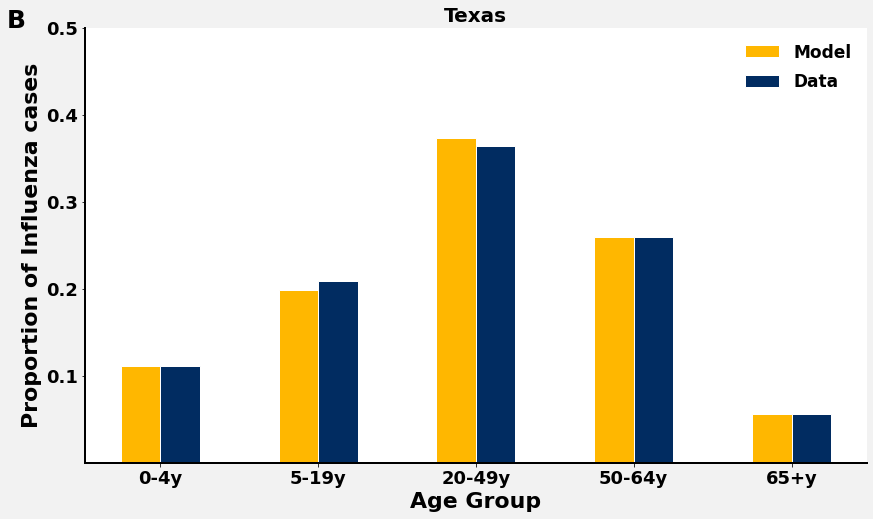

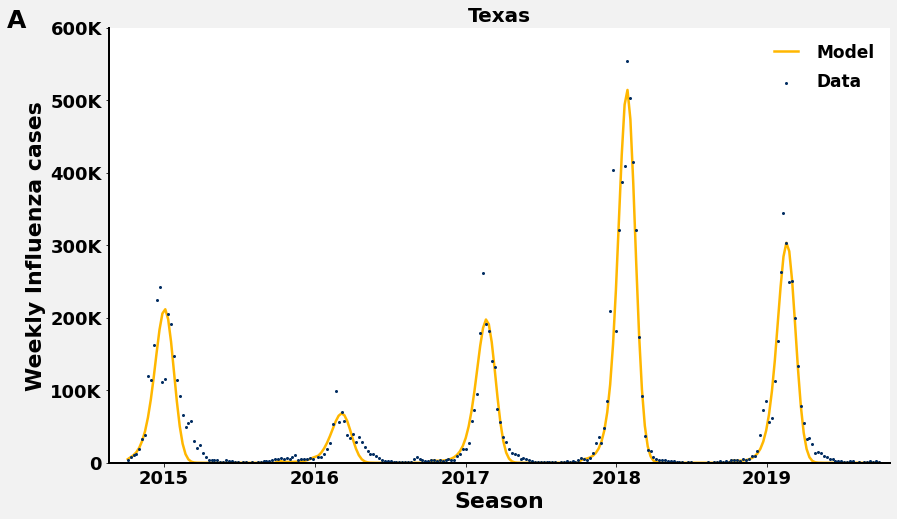

In [25]:
fig_cal1_tx,ax_cal1_tx =plot_calibration_age_group(proportion_mdl= proportion_mdl_tx, proportion_dt= proportion_dt_tx, state= 'Texas', 
                           fntsize=14, panel='B')
fig_cal2_tx,ax_cal2_tx = plot_calibration(calibrate_mdl= tx_calibrate_mdl, state_data= tx_data, population= 28995881, state= 'Texas',
                ylim_max= 600000, fntsize=14, panel='A')
fig_cal2_tx.savefig(fig_loc.format('calibration_cases_TX'))
fig_cal1_tx.savefig(fig_loc.format('calibration_proportion_TX'))

### plot of treated the baseline in 48 hours:

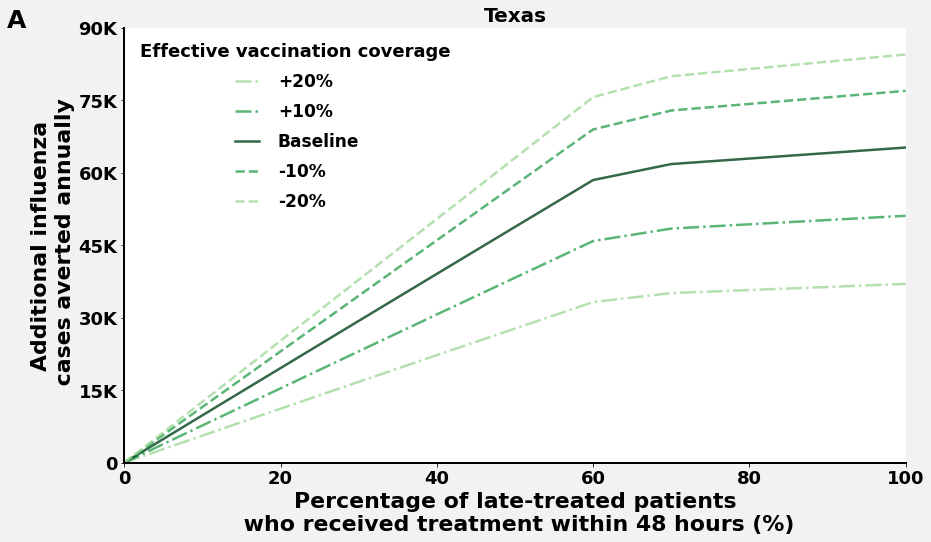

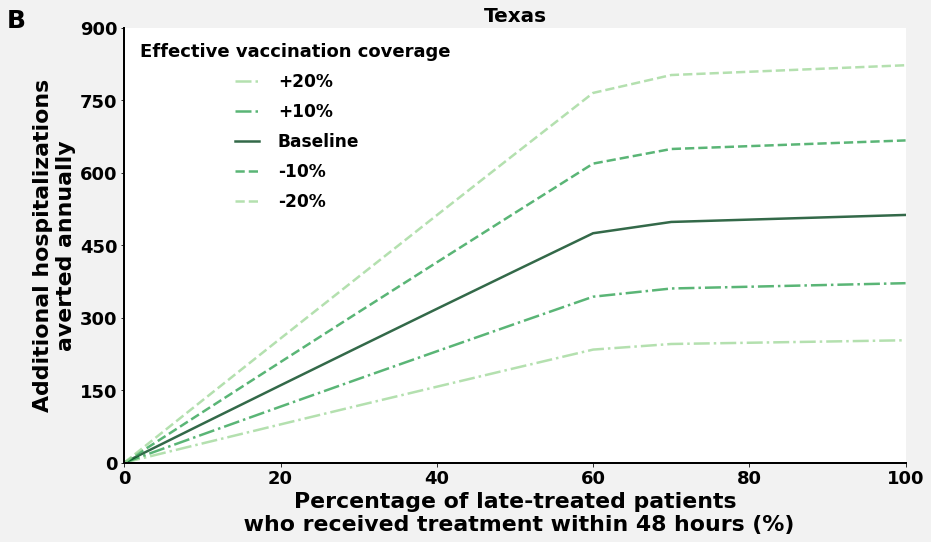

In [29]:
res_shift_tx = shifting_tratments_plots(tx_params_fitted,  
                        'Texas', 28995881, 90000, 47000, 900, 47000, title = 'Texas',fntsize=14, panel=['A','B'])
res_shift_tx[0].savefig(fig_loc.format('shift_cases_TX'))
res_shift_tx[2].savefig(fig_loc.format('shift_hosp_TX'))

### Plot Averted with precent of treatment changment

In [30]:
plt.show(res_shift_tx[0])

In [31]:
# baseline_tx = {}
# for vacc_incerease in [0.8,0.9,1,1.1,1.2]:
#     baseline_tx[vacc_incerease] = model.get_baseline_results_age_group('Texas', range(2015,2020), tx_params_fitted,
#                                                    np.minimum(model.vaccination_coverage['Texas'] * vacc_incerease, 1.0))

# treatment_increase = np.arange(0.1,0.31,0.01)
# increase_within_2d_res = model.increase_treated('Texas', range(2015,2020),
#                                                 tx_params_fitted,treatment_increase, model.vaccination_coverage['Texas'],
#                                                baseline_tx)

# population = 28.7 * 10 **(6)

#### Cases

# increse_2days_tx = increase_within_2d_res['Cases']
# increse_2days_tx['averted'] = increse_2days_tx.baseline_cases - increse_2days_tx.new_policy_cases

# increse_2days_tx['averted'] = (increse_2days_tx.apply(lambda x: 0 if x.percentage_increase == 0 else x.averted, axis=1)) * population

# num_HR = (np.array(model.demography['Texas']) * population * np.array([0.052, 0.106, 0.149, 0.33, 0.512])).sum()

# increse_2days_tx['averted_per_treat'] = increse_2days_tx.apply(lambda x: x.averted /\
#                                                                (x.baseline_cases * num_HR * x.shifted)
#                                                                if x.shifted > 0 else 0, axis=1)

# increse_2days_tx_avg = increse_2days_tx.groupby(['percentage_increase', 'vacc_coverage']).mean()
# increse_2days_tx_avg_cases = increse_2days_tx_avg['averted'].copy()
# increse_2days_tx_avg_cases_treat = increse_2days_tx_avg['averted_per_treat'].copy()

# (increse_2days_tx_avg_cases.unstack()[['+20%','+10%','0%','-10%','-20%']]).plot(style=['-.','-.','-','--','--'],cmap=grayscale_cmap('twilight'),
#                                             alpha=1, figsize=(8,5))
# ax = plt.gca()
# ax.yaxis.grid(True)

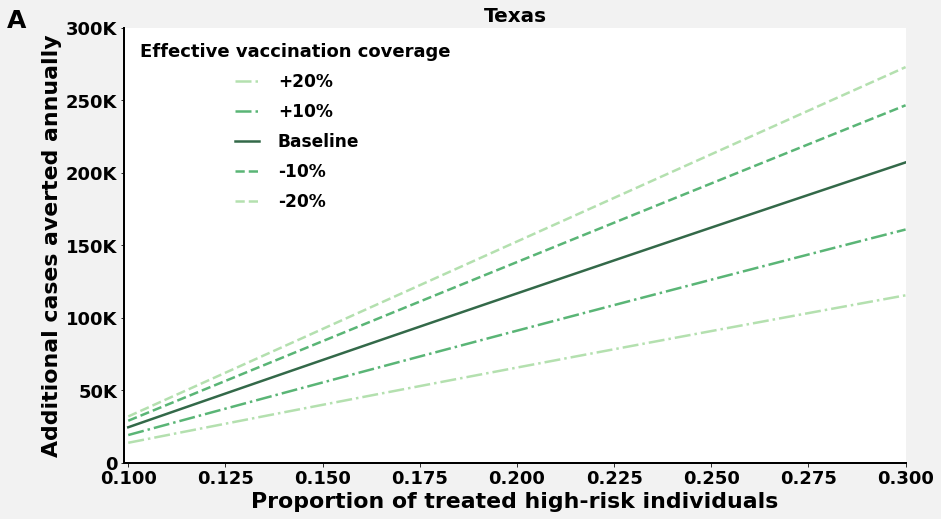

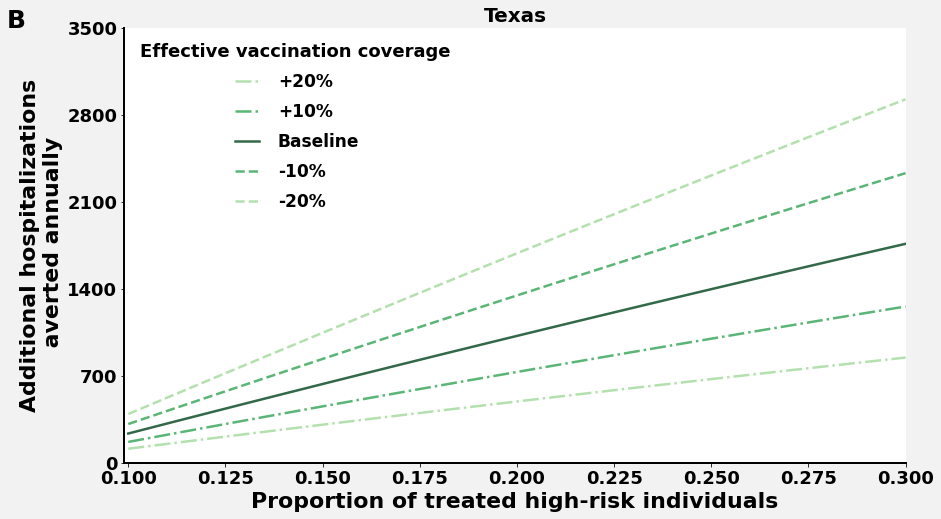

In [32]:
res_increase_tx = increase_treatment_plots(tx_params_fitted,'Texas', 28995881, title='Texas',fntsize=14,
                                           panel=['A','B'],  ylim_max_hosp= 3500, ylim_max_cases=300000, jump_hosp=700)
res_increase_tx[0].savefig(fig_loc.format('increase_cases_TX'))
res_increase_tx[2].savefig(fig_loc.format('increase_hosp_TX'))

In [33]:
#### Hospitalizations

# increse_2days_hosp_tx = increase_within_2d_res['Hospital']
# increse_2days_hosp_tx['averted'] = increse_2days_hosp_tx.baseline_hospital - increse_2days_hosp_tx.new_policy_hospital

# population = 28.7 * 10 **(6)
# increse_2days_hosp_tx['averted'] = (increse_2days_hosp_tx.apply(lambda x: 0 if x.percentage_increase == 0 else x.averted,
#                                                                 axis=1)) * population

# num_HR = (np.array(model.demography['Texas']) * population * np.array([0.052, 0.106, 0.149, 0.33, 0.512])).sum()

# increse_2days_hosp_tx['averted_per_treat'] = increse_2days_hosp_tx.apply(lambda x: x.averted /\
#                                                                (x.baseline_hospital * num_HR * x.shifted)
#                                                                if x.shifted > 0 else 0, axis=1)

# increse_2days_tx_avg_hosp = increse_2days_hosp_tx.groupby(['percentage_increase', 'vacc_coverage']).mean()
# increse_2days_tx_avg_averted_hosp = increse_2days_tx_avg_hosp['averted'].copy()
# increse_2days_tx_avg_hosp_treat = increse_2days_tx_avg_hosp['averted_per_treat'].copy()

# (increse_2days_tx_avg_averted_hosp.unstack()).plot(style=['-.','-.','-','--','--'],cmap=grayscale_cmap('twilight'),
#                                             alpha=1, figsize=(8,5))
# # ax = plt.gca()
# # ax.yaxis.grid(True)

### Plot Averted by age group

#### baseline 2d:

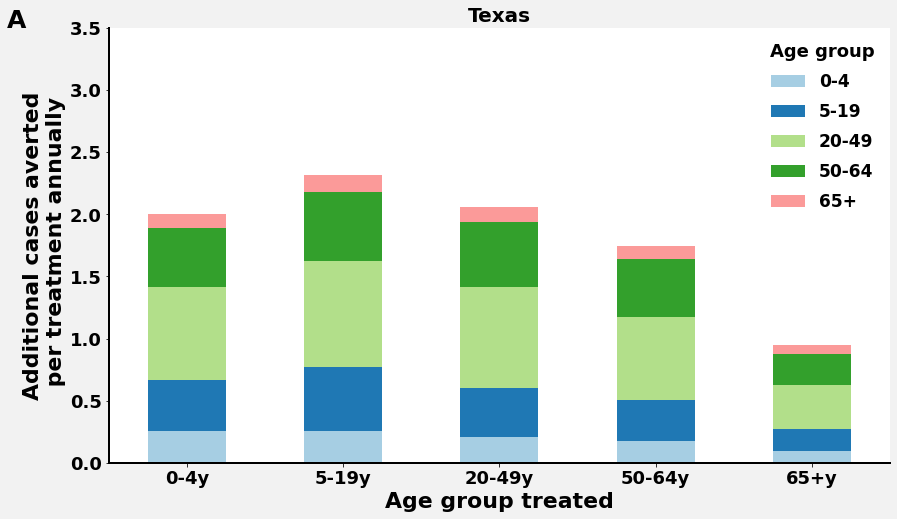

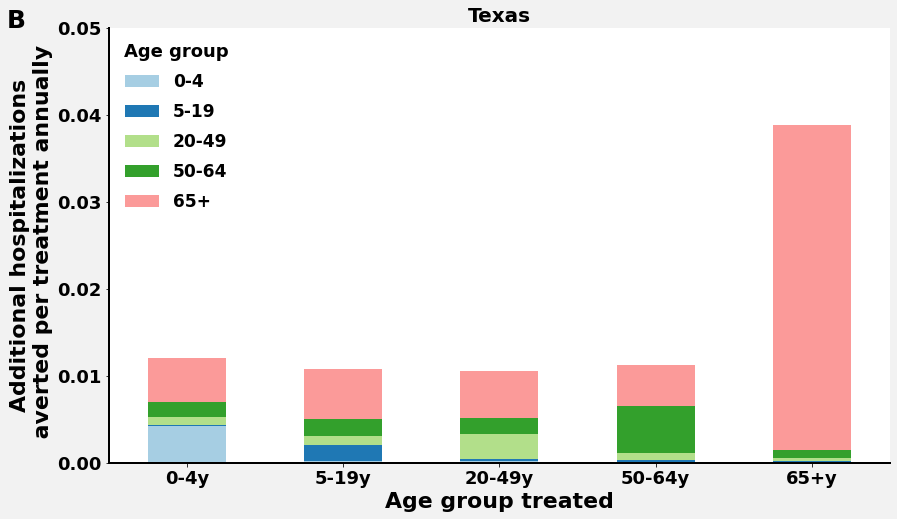

In [34]:
res_bars_tx = pre_treatment_age_group_plots(fitted_params= tx_params_fitted, state= 'Texas', population= 28995881,
                               title='Texas', panel=['A','B'], fntsize=14)
res_bars_tx[0].savefig(fig_loc.format('bars_cases_TX'))
res_bars_tx[2].savefig(fig_loc.format('bars_hosp_TX'))

### 2-way analysis

44.86
                                   season  baseline_cases  new_policy_cases  \
vacc_coverage percentage_increase                                             
0.6           0.10                 2017.0        0.210476          0.209364   
              0.15                 2017.0        0.210476          0.207268   
              0.20                 2017.0        0.210476          0.205159   
              0.30                 2017.0        0.210476          0.200903   
              0.40                 2017.0        0.210476          0.196600   
...                                   ...             ...               ...   
1.4           0.10                 2017.0        0.013345          0.013144   
              0.15                 2017.0        0.013345          0.012760   
              0.20                 2017.0        0.013345          0.012386   
              0.30                 2017.0        0.013345          0.011668   
              0.40                 2017.0     

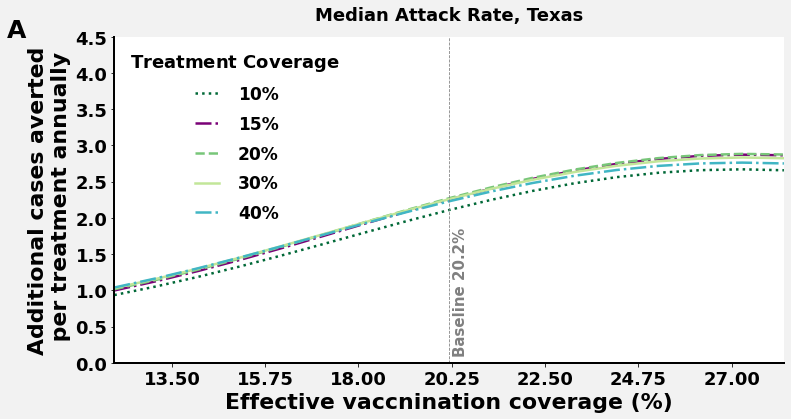

In [35]:
vacc_inc = np.arange(0.6,1.45,0.05)
treat_inc = [0.1,0.15,0.2,0.3,0.4]
res_med_tx = treatment_vaccination_relation_plot(fitted_params= tx_params_fitted, state= 'Texas', population= 28995881,
                                    vacc_increase_vals= vacc_inc, treatment_increase_vals= treat_inc, 
                                        seasons= range(2015,2020), avg_vacc_coverage= 44.86, ylim_min= 0.0, ylim_max= 4.5,
                                   plt_title= 'Median Attack Rate, Texas',  panel= 'A', fntsize=16,median_ar=True)
res_med_tx[0].savefig(fig_loc.format('2-way analysis median TX'))

44.86
                                   season  baseline_cases  new_policy_cases  \
vacc_coverage percentage_increase                                             
0.6           0.10                 2016.0        0.148143          0.146646   
              0.15                 2016.0        0.148143          0.143823   
              0.20                 2016.0        0.148143          0.140997   
              0.30                 2016.0        0.148143          0.135337   
              0.40                 2016.0        0.148143          0.129679   
...                                   ...             ...               ...   
1.4           0.10                 2016.0        0.001942          0.001906   
              0.15                 2016.0        0.001942          0.001837   
              0.20                 2016.0        0.001942          0.001770   
              0.30                 2016.0        0.001942          0.001645   
              0.40                 2016.0     

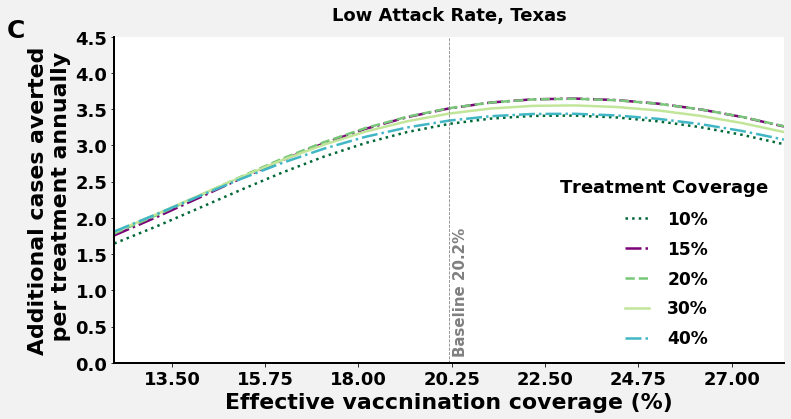

In [36]:
vacc_inc = np.arange(0.6,1.45,0.05)
treat_inc = [0.1,0.15,0.2,0.3,0.4]
res_low_tx = treatment_vaccination_relation_plot(fitted_params= tx_params_fitted, state= 'Texas', population= 28995881,
                                    vacc_increase_vals= vacc_inc, treatment_increase_vals= treat_inc, 
                                        seasons= [2016], avg_vacc_coverage= 44.86, ylim_min= 0, ylim_max=4.5,
                                   plt_title = 'Low Attack Rate, Texas', panel='C',fntsize=16, median_ar=True)
res_low_tx[0].savefig(fig_loc.format('2-way analysis low TX'))

44.86
                                   season  baseline_cases  new_policy_cases  \
vacc_coverage percentage_increase                                             
0.6           0.10                 2018.0        0.272671          0.271852   
              0.15                 2018.0        0.272671          0.270304   
              0.20                 2018.0        0.272671          0.268742   
              0.30                 2018.0        0.272671          0.265575   
              0.40                 2018.0        0.272671          0.262348   
...                                   ...             ...               ...   
1.4           0.10                 2018.0        0.031882          0.031415   
              0.15                 2018.0        0.031882          0.030524   
              0.20                 2018.0        0.031882          0.029652   
              0.30                 2018.0        0.031882          0.027966   
              0.40                 2018.0     

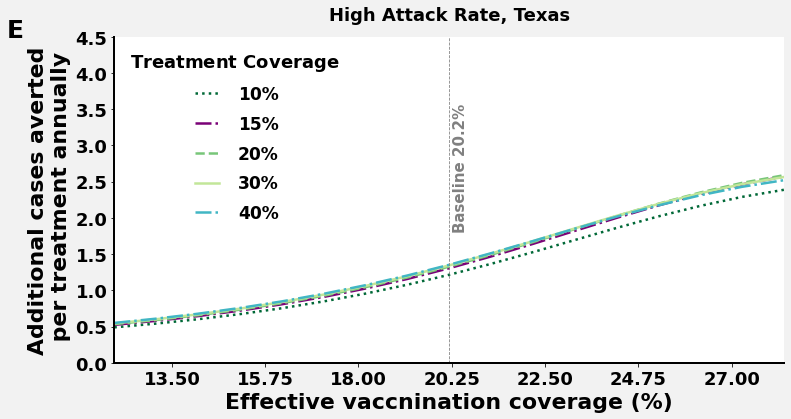

In [37]:
vacc_inc = np.arange(0.6,1.45,0.05)
treat_inc = [0.1,0.15,0.2,0.3,0.4]
res_high_tx = treatment_vaccination_relation_plot(fitted_params= tx_params_fitted, state= 'Texas', population= 28995881,
                                    vacc_increase_vals= vacc_inc, treatment_increase_vals= treat_inc, 
                                        seasons= [2018], avg_vacc_coverage= 44.86, ylim_min= 0.0, ylim_max= 4.5,
                                   plt_title= 'High Attack Rate, Texas',  panel= 'E',fntsize=16,high_ar=True)
res_high_tx[0].savefig(fig_loc.format('2-way analysis high TX'))

## California

### California data

In [38]:
# loading attack rate
attack_rate_mdl_ca = pd.read_pickle('./model_data/CA_model_attackrate.pickle')
attack_rate_dt_ca = pd.read_pickle('./model_data/CA_data_attackrate.pickle')

# loading proportion
proportion_mdl_ca = pd.read_pickle('./model_data/CA_model_proportion.pickle')
proportion_dt_ca = pd.read_pickle('./model_data/CA_data_proportion.pickle')

# loading fitted params
with open('./model_data/CA_fitted_parameters.pickle', 'rb') as pickle_in:
    ca_params_fitted = pickle.load(pickle_in)
    
#loading vaccination coverage
with open('./model_data/ca_vaccinatio_coverage.pickle', 'rb') as pickle_in:
    ca_vacc_coverage = pickle.load(pickle_in)
    
# Loading calibrated results
ca_calibrate_mdl = pd.read_pickle('./model_data/CA_mdl_fitting_res.pickle')
ca_data = pd.read_pickle('./model_data/CA_data_fitting_res.pickle')

### Plot calibration for California

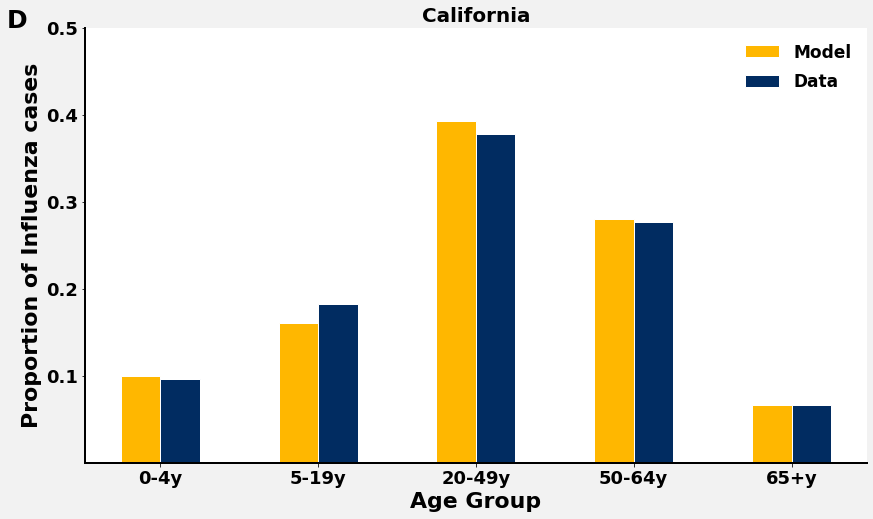

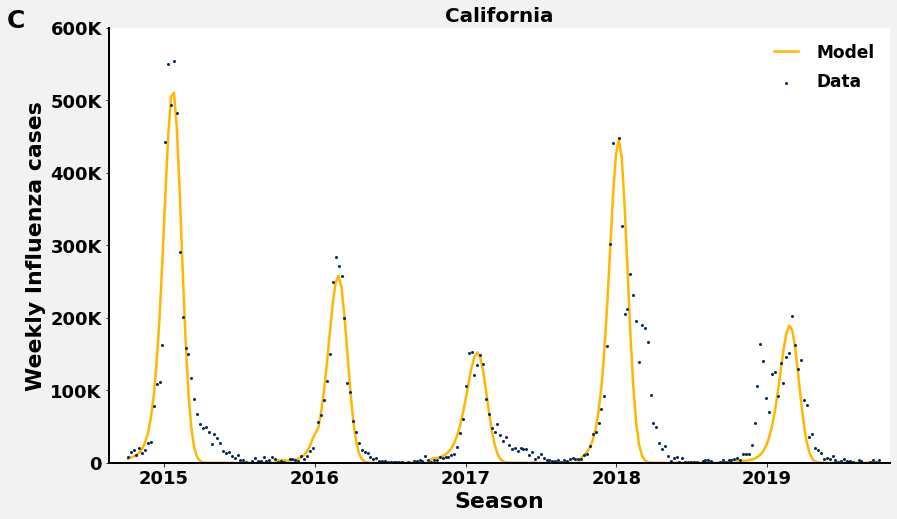

In [41]:
fig_cal1_ca,ax_cal1_ca=plot_calibration_age_group(proportion_mdl= proportion_mdl_ca, proportion_dt= proportion_dt_ca, state= 'California',fntsize=14, panel='D')
fig_cal2_ca,ax_cal2_ca=plot_calibration(calibrate_mdl= ca_calibrate_mdl, state_data= ca_data, population= 39512223, state= 'California',
                ylim_max= 600000,fntsize=14, panel='C')
fig_cal2_ca.savefig(fig_loc.format('calibration_cases_CA'))
fig_cal1_ca.savefig(fig_loc.format('calibration_proportion_CA'))

### plot of treated the baseline in 48 hours:

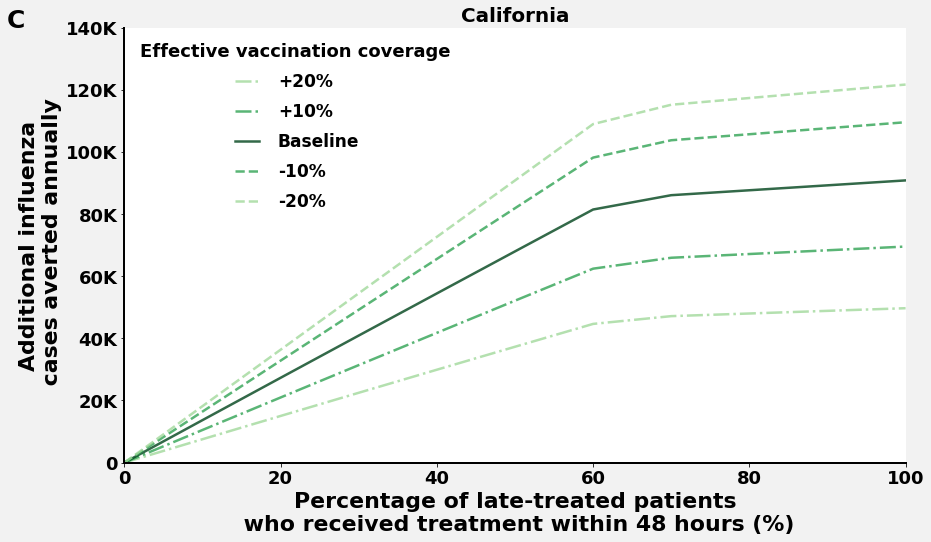

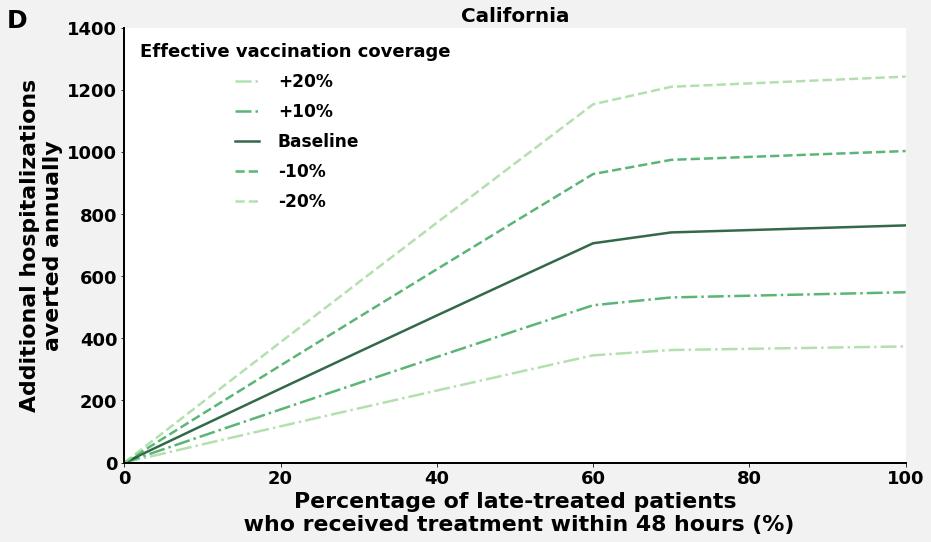

In [42]:
res_shift_ca = shifting_tratments_plots(fitted_params= ca_params_fitted,  state= 'California', 
                         population= 39512223, ylim_max_cases= 140000, xlim_max_cases= 63000, 
                         ylim_max_hosp= 1350, xlim_max_hosp= 63000, title='California',fntsize=14, panel=['C','D'],
                                       jump=20000, jump_hosp=200)
res_shift_ca[0].savefig(fig_loc.format('shift_cases_CA'))
res_shift_ca[2].savefig(fig_loc.format('shift_hosp_CA'))

### Plot Averted with precent of treatment changment

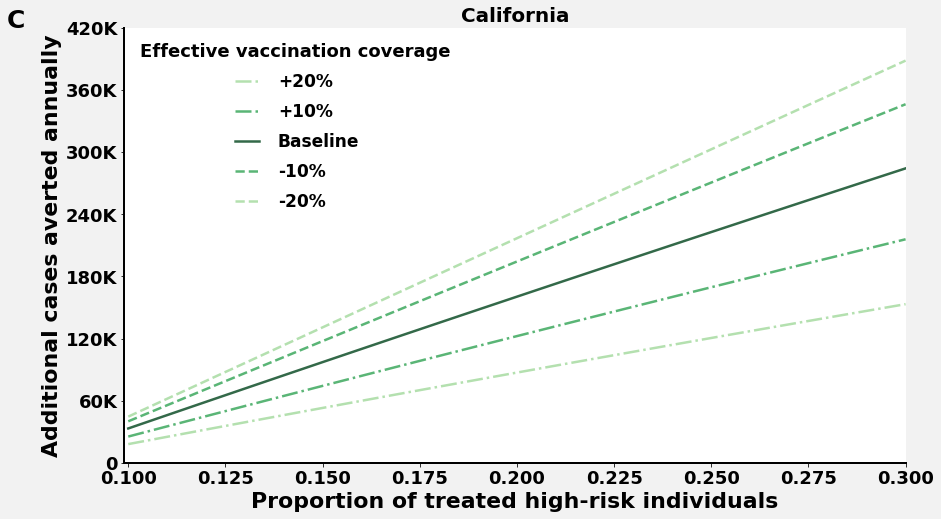

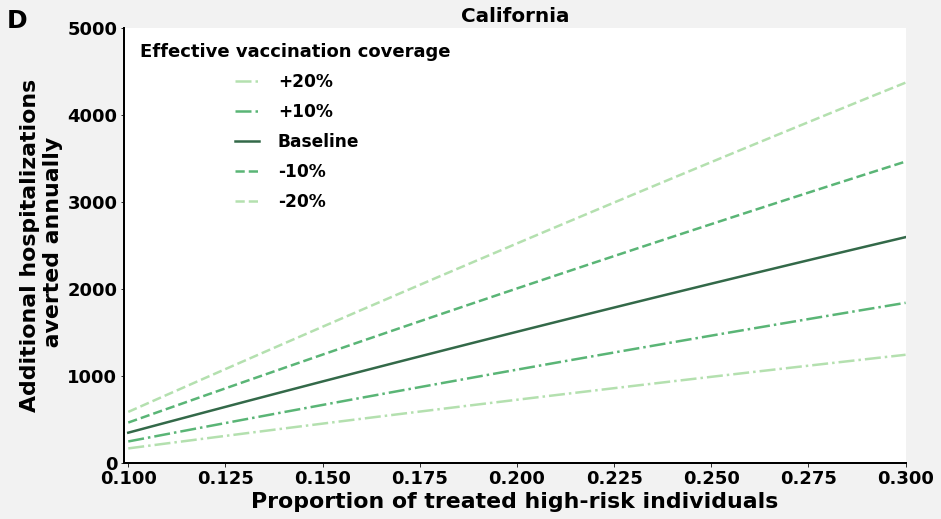

In [43]:
res_increase_ca = increase_treatment_plots(fitted_params= ca_params_fitted, state= 'California', population= 39512223, title= 'California',
                        fntsize=14, panel=['C','D'], ylim_max_cases=420000, jump=60000, ylim_max_hosp=5000, jump_hosp=1000)

res_increase_ca[0].savefig(fig_loc.format('increase_cases_CA'))
res_increase_ca[2].savefig(fig_loc.format('increase_hosp_CA'))

### Plot Averted by age group

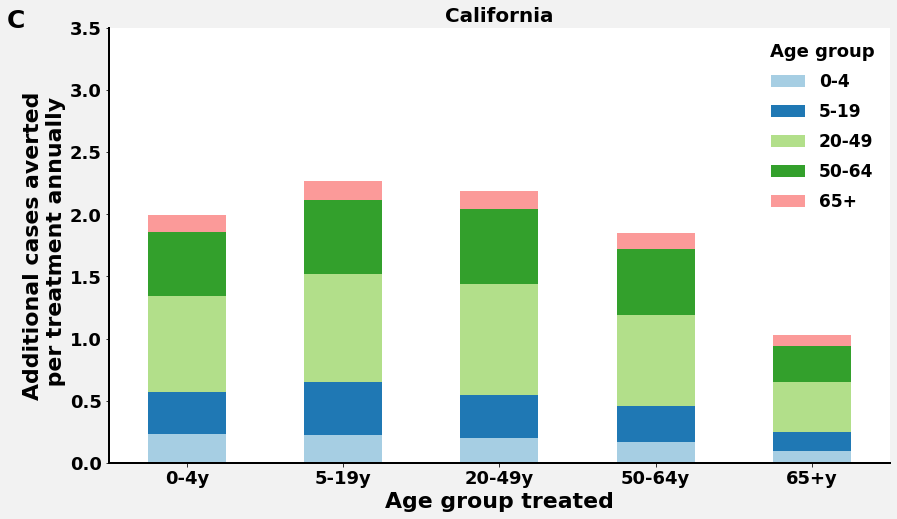

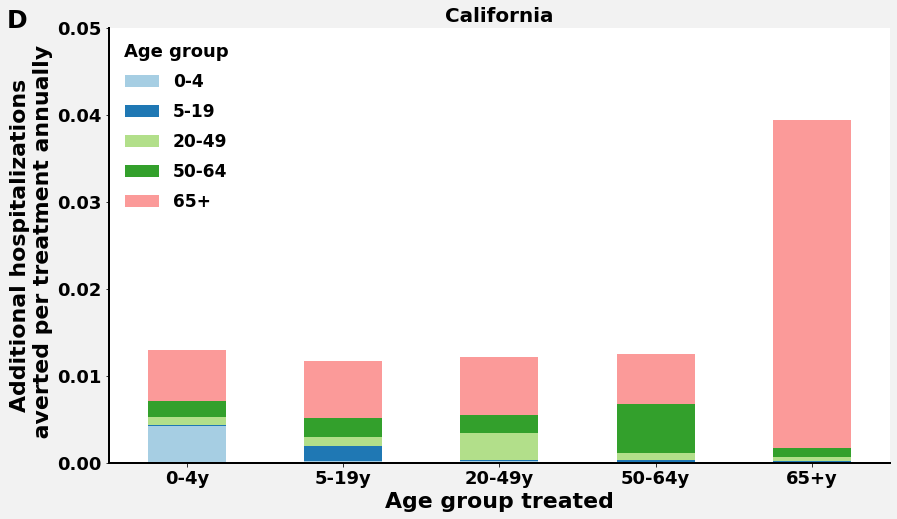

In [71]:
res_bars_ca = pre_treatment_age_group_plots(fitted_params= ca_params_fitted, state= 'California', population= 39512223, title= 'California',
                              fntsize=14, panel=['C','D'])
res_bars_ca[0].savefig(fig_loc.format('bars_cases_CA'))
res_bars_ca[2].savefig(fig_loc.format('bars_hosp_CA'))

### 2-way analysis

43.975
                                   season  baseline_cases  new_policy_cases  \
vacc_coverage percentage_increase                                             
0.6           0.10                 2017.0        0.196705          0.195560   
              0.15                 2017.0        0.196705          0.193348   
              0.20                 2017.0        0.196705          0.191121   
              0.30                 2017.0        0.196705          0.186627   
              0.40                 2017.0        0.196705          0.182081   
...                                   ...             ...               ...   
1.4           0.10                 2017.0        0.013515          0.013317   
              0.15                 2017.0        0.013515          0.012933   
              0.20                 2017.0        0.013515          0.012558   
              0.30                 2017.0        0.013515          0.011840   
              0.40                 2017.0    

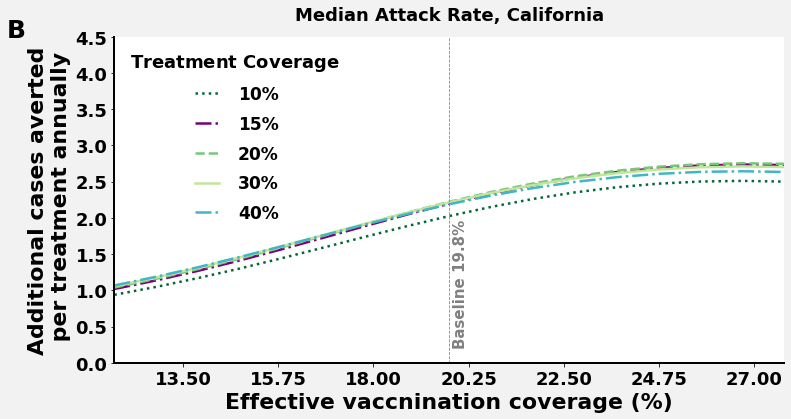

In [45]:
vacc_inc = np.arange(0.6,1.45,0.05)
treat_inc = [0.1,0.15,0.2,0.3,0.4]
res_med_ca = treatment_vaccination_relation_plot(fitted_params= ca_params_fitted, state= 'California', population= 39512223,
                                    vacc_increase_vals= vacc_inc, treatment_increase_vals= treat_inc, 
                                        seasons= range(2015,2020), avg_vacc_coverage= 43.975, ylim_min= 0, ylim_max= 4.5,
                                   plt_title= 'Median Attack Rate, California',  panel= "B", fntsize=16)
res_med_ca[0].savefig(fig_loc.format('2-way analysis median CA'))

43.975
                                   season  baseline_cases  new_policy_cases  \
vacc_coverage percentage_increase                                             
0.6           0.10                 2016.0        0.205156          0.203877   
              0.15                 2016.0        0.205156          0.201398   
              0.20                 2016.0        0.205156          0.198895   
              0.30                 2016.0        0.205156          0.193820   
              0.40                 2016.0        0.205156          0.188655   
...                                   ...             ...               ...   
1.4           0.10                 2016.0        0.006726          0.006594   
              0.15                 2016.0        0.006726          0.006336   
              0.20                 2016.0        0.006726          0.006088   
              0.30                 2016.0        0.006726          0.005620   
              0.40                 2016.0    

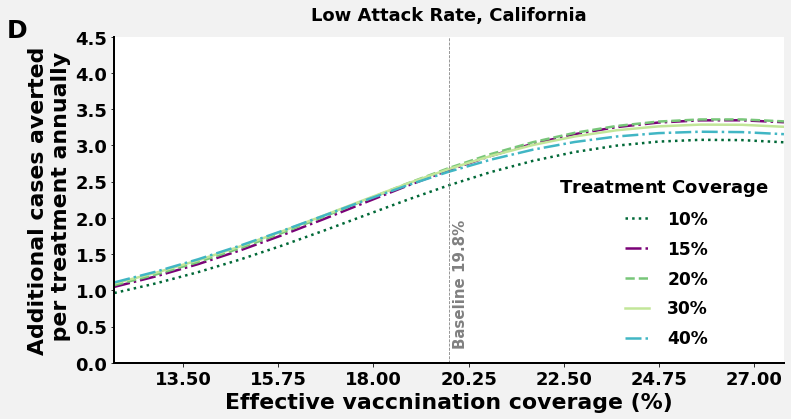

In [46]:
vacc_inc = np.arange(0.6,1.45,0.05)
treat_inc = [0.1,0.15,0.2,0.3,0.4]
res_low_ca = treatment_vaccination_relation_plot(fitted_params= ca_params_fitted, state= 'California', population= 39512223,
                                    vacc_increase_vals= vacc_inc, treatment_increase_vals= treat_inc, 
                                        seasons= [2016], avg_vacc_coverage= 43.975, ylim_min= 0.0, ylim_max=4.5,
                                   plt_title = 'Low Attack Rate, California', panel="D", fntsize=16)
res_low_ca[0].savefig(fig_loc.format('2-way analysis low CA'))

43.975
                                   season  baseline_cases  new_policy_cases  \
vacc_coverage percentage_increase                                             
0.6           0.10                 2018.0        0.212574          0.211628   
              0.15                 2018.0        0.212574          0.209814   
              0.20                 2018.0        0.212574          0.207990   
              0.30                 2018.0        0.212574          0.204311   
              0.40                 2018.0        0.212574          0.200592   
...                                   ...             ...               ...   
1.4           0.10                 2018.0        0.025352          0.025046   
              0.15                 2018.0        0.025352          0.024453   
              0.20                 2018.0        0.025352          0.023871   
              0.30                 2018.0        0.025352          0.022743   
              0.40                 2018.0    

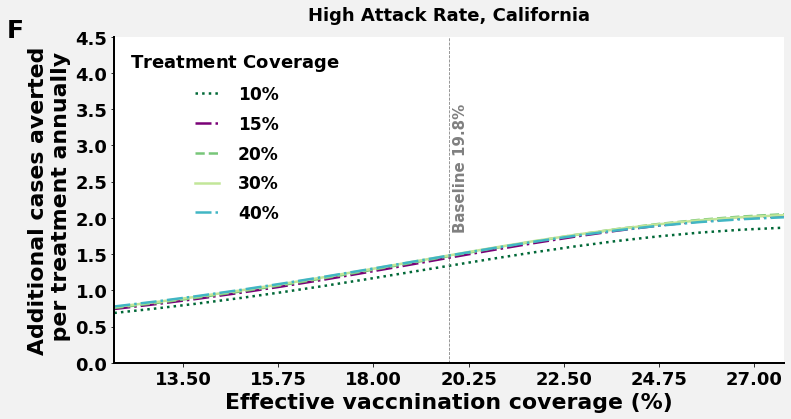

In [47]:
vacc_inc = np.arange(0.6,1.45,0.05)
treat_inc = [0.1,0.15,0.2,0.3,0.4]
res_high_ca = treatment_vaccination_relation_plot(fitted_params= ca_params_fitted, state= 'California', population= 39512223,
                                    vacc_increase_vals= vacc_inc, treatment_increase_vals= treat_inc, 
                                        seasons= [2018], avg_vacc_coverage= 43.975, ylim_min= 0.0, ylim_max=4.5,
                                    plt_title = 'High Attack Rate, California', panel= "F", fntsize=16,high_ar=True)
res_high_ca[0].savefig(fig_loc.format('2-way analysis high CA'))

## Connecticut

### Connecticut data

In [48]:
# loading attack rate
attack_rate_mdl_ct = pd.read_pickle('./model_data/CT_model_attackrate.pickle')
attack_rate_dt_ct = pd.read_pickle('./model_data/CT_data_attackrate.pickle')

# loading proportion
proportion_mdl_ct = pd.read_pickle('./model_data/CT_model_proportion.pickle')
proportion_dt_ct = pd.read_pickle('./model_data/CT_data_proportion.pickle')

# loading fitted params
with open('./model_data/CT_fitted_parameters.pickle', 'rb') as pickle_in:
    ct_params_fitted = pickle.load(pickle_in)
    
#loading vaccination coverage
with open('./model_data/ct_vaccinatio_coverage.pickle', 'rb') as pickle_in:
    ct_vacc_coverage = pickle.load(pickle_in)
    
# Loading calibrated results
ct_calibrate_mdl = pd.read_pickle('./model_data/CT_mdl_fitting_res.pickle')
ct_data = pd.read_pickle('./model_data/CT_data_fitting_res.pickle')

In [49]:
ct_calibrate_mdl['total'].to_csv('CT fit results.csv')

### Plot calibration for Connecticut

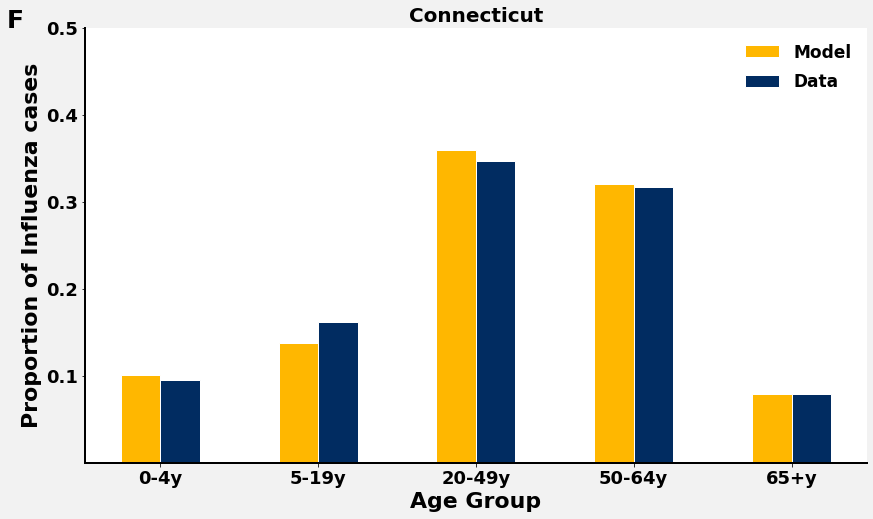

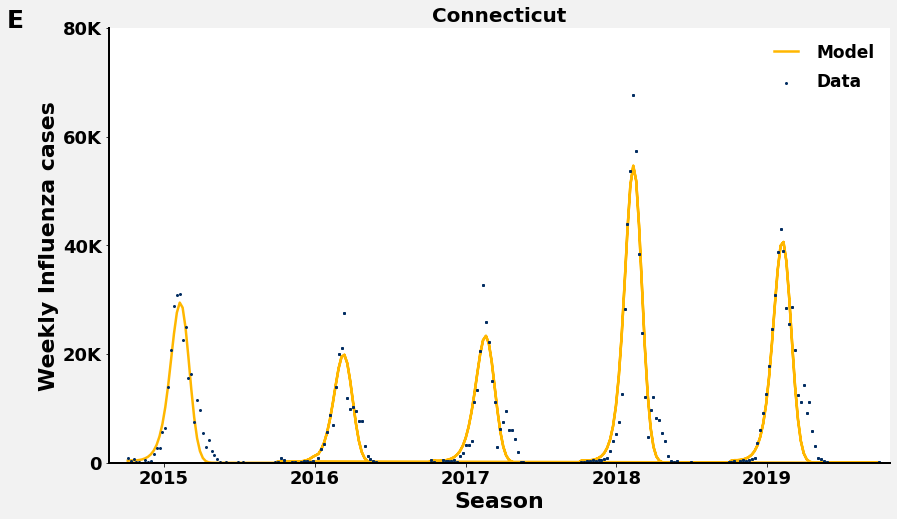

In [52]:
fig_cal1_ct,ax_cal1_ct = plot_calibration_age_group(proportion_mdl= proportion_mdl_ct, proportion_dt= proportion_dt_ct, state= 'Connecticut', panel='F')
fig_cal2_ct,ax_cal2_ct = plot_calibration(calibrate_mdl= ct_calibrate_mdl, state_data= ct_data, population= 3565287, state= 'Connecticut',
                ylim_max= 80000, panel='E', jump=20000)
fig_cal2_ct.savefig(fig_loc.format('calibration_cases_CT'))
fig_cal1_ct.savefig(fig_loc.format('calibration_proportion_CT'))

### plot of treated the baseline in 48 hours:

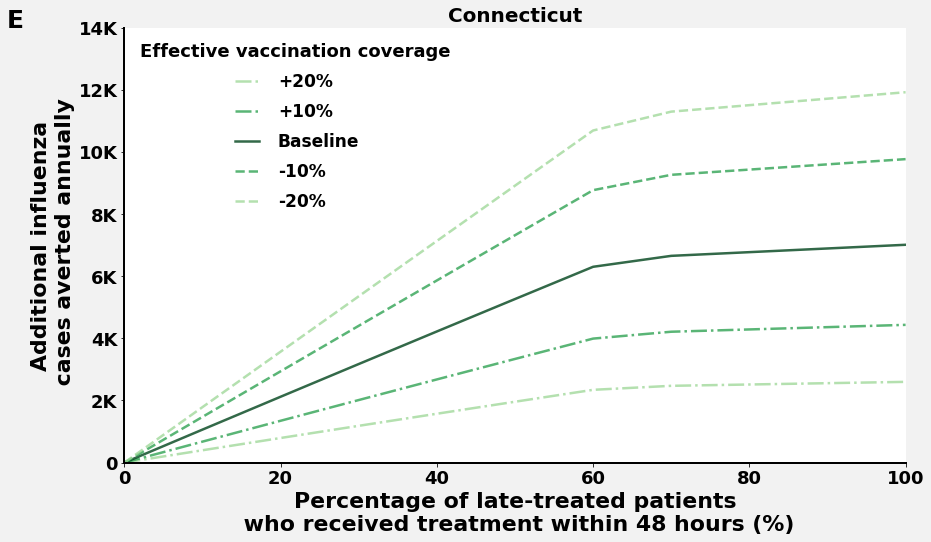

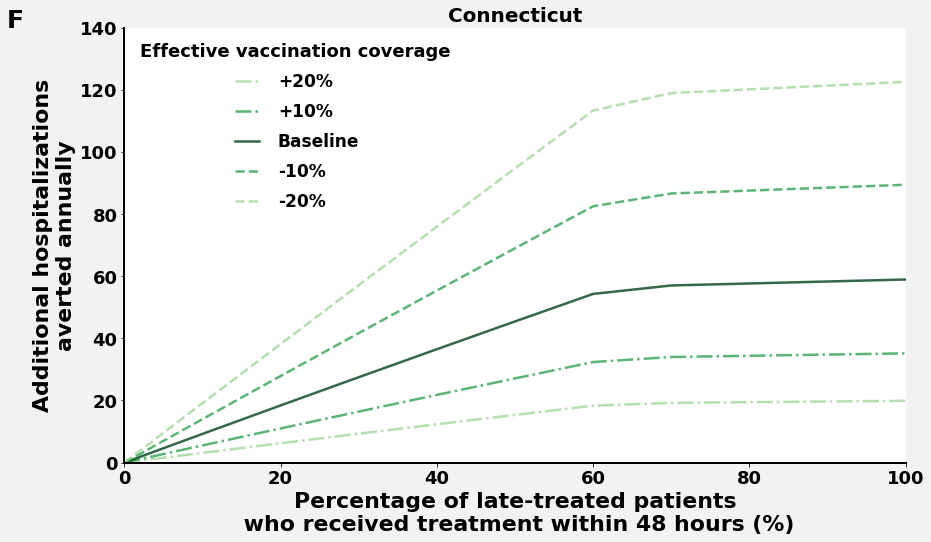

In [53]:
res_shift_ct = shifting_tratments_plots(fitted_params= ct_params_fitted,  state= 'Connecticut', 
                         population= 3565287, ylim_max_cases= 13000, xlim_max_cases= 4000, 
                         ylim_max_hosp= 140, xlim_max_hosp= 4000, fntsize=14, panel=['E','F'],title='Connecticut',
                                       jump_hosp=20, jump=2000)
res_shift_ct[0].savefig(fig_loc.format('shift_cases_CT'))
res_shift_ct[2].savefig(fig_loc.format('shift_hosp_CT'))

### Plot Averted with percent of treatment change

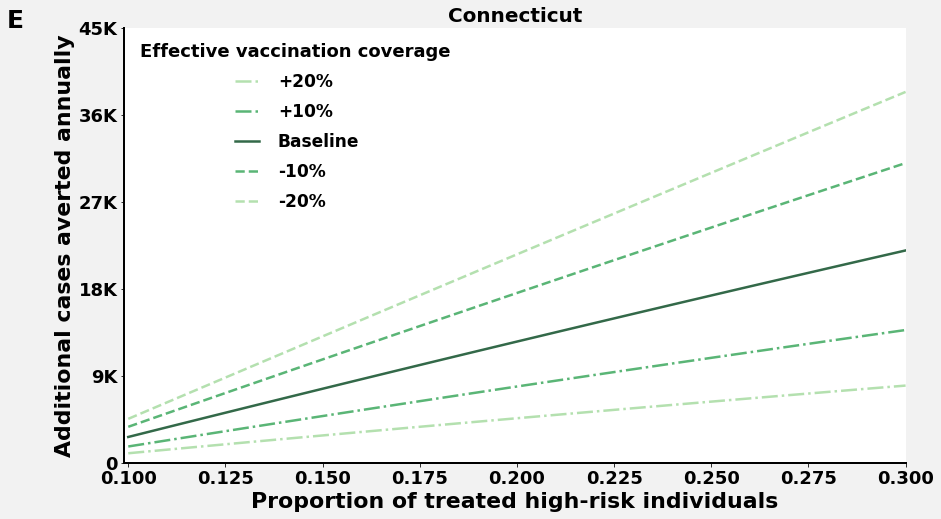

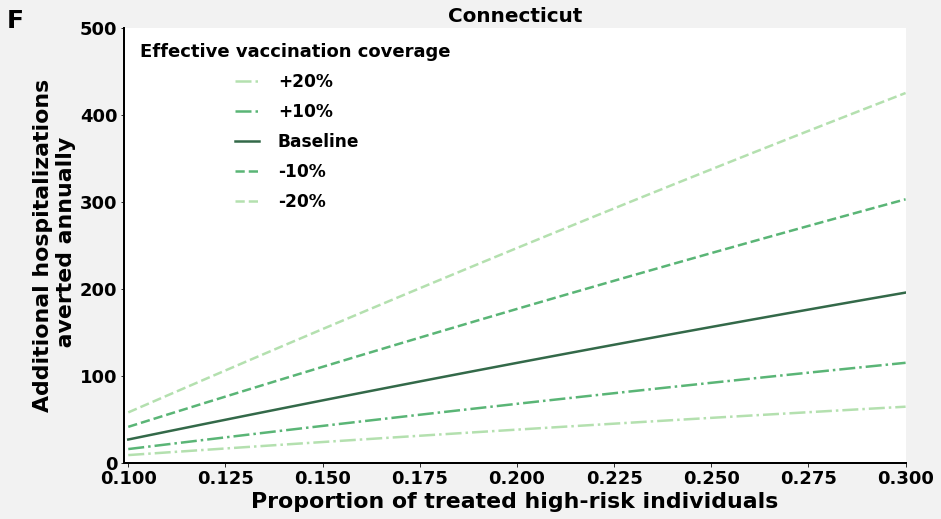

In [54]:
res_increase_ct = increase_treatment_plots(ct_params_fitted,'Connecticut', 3565287, fntsize=14, panel=['E','F'],
                        ylim_max_hosp=500, jump_hosp=100, ylim_max_cases=45000, jump=9000, title='Connecticut')
res_increase_ct[0].savefig(fig_loc.format('increase_cases_CT'))
res_increase_ct[2].savefig(fig_loc.format('increase_hosp_CT'))

### Plot Averted by age group

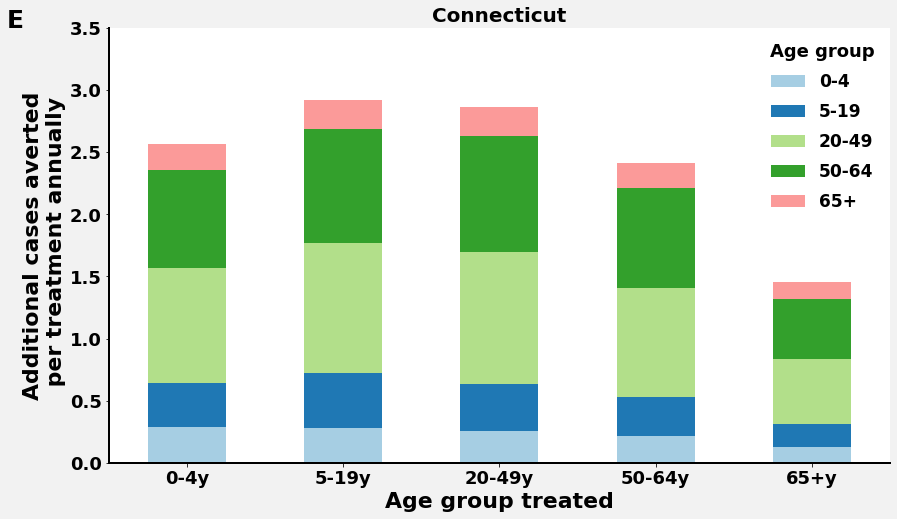

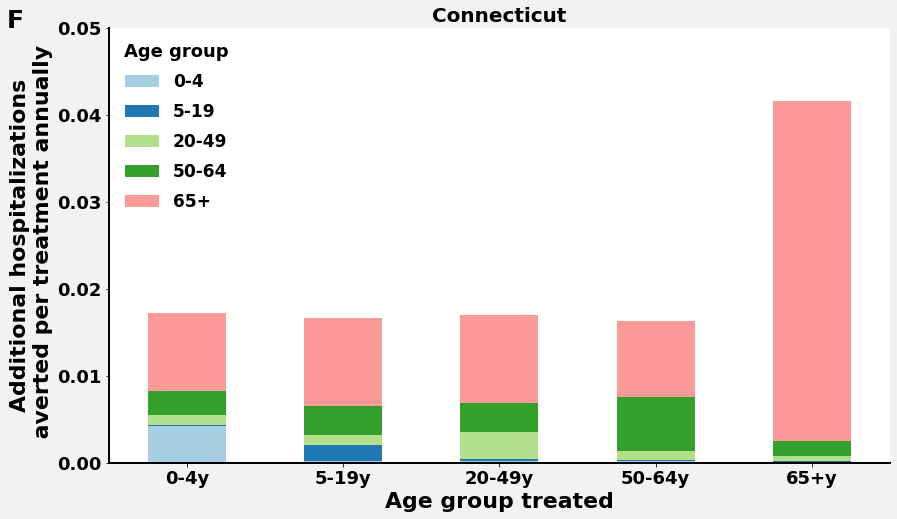

In [55]:
res_bars_ct = pre_treatment_age_group_plots(fitted_params= ct_params_fitted, state= 'Connecticut', population= 3565287,
                              fntsize=14, panel=['E','F'], title='Connecticut')
res_bars_ct[0].savefig(fig_loc.format('bars_cases_CT'))
res_bars_ct[2].savefig(fig_loc.format('bars_hosp_CT'))

### 2-way analysis

51.24
                                   season  baseline_cases  new_policy_cases  \
vacc_coverage percentage_increase                                             
0.6           0.10                 2017.0        0.188097          0.186753   
              0.15                 2017.0        0.188097          0.184224   
              0.20                 2017.0        0.188097          0.181675   
              0.30                 2017.0        0.188097          0.176522   
              0.40                 2017.0        0.188097          0.171299   
...                                   ...             ...               ...   
1.4           0.10                 2017.0        0.004767          0.004675   
              0.15                 2017.0        0.004767          0.004502   
              0.20                 2017.0        0.004767          0.004335   
              0.30                 2017.0        0.004767          0.004020   
              0.40                 2017.0     

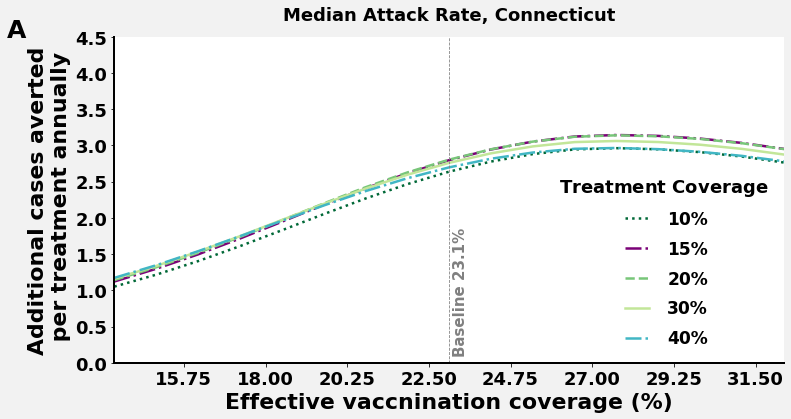

In [56]:
vacc_inc = np.arange(0.6,1.45,0.05)
treat_inc = [0.1,0.15,0.2,0.3,0.4]
res_med_ct = treatment_vaccination_relation_plot(fitted_params= ct_params_fitted, state= 'Connecticut', population= 3565287,
                                    vacc_increase_vals= vacc_inc, treatment_increase_vals= treat_inc, 
                                        seasons= range(2015,2020), avg_vacc_coverage= 51.24, ylim_min= 0.0, ylim_max= 4.5,
                                   plt_title= 'Median Attack Rate, Connecticut',  panel= 'A', fntsize=16,median_ar=True)
res_med_ct[0].savefig(fig_loc.format('2-way analysis median CT'))

51.24
                                   season  baseline_cases  new_policy_cases  \
vacc_coverage percentage_increase                                             
0.6           0.10                 2016.0        0.164510          0.162868   
              0.15                 2016.0        0.164510          0.159768   
              0.20                 2016.0        0.164510          0.156650   
              0.30                 2016.0        0.164510          0.150360   
              0.40                 2016.0        0.164510          0.144012   
...                                   ...             ...               ...   
1.4           0.10                 2016.0        0.001517          0.001485   
              0.15                 2016.0        0.001517          0.001425   
              0.20                 2016.0        0.001517          0.001367   
              0.30                 2016.0        0.001517          0.001259   
              0.40                 2016.0     

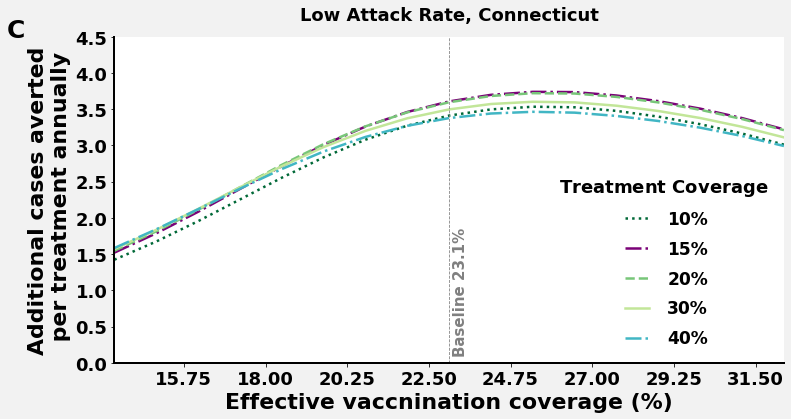

In [57]:
vacc_inc = np.arange(0.6,1.45,0.05)
treat_inc = [0.1,0.15,0.2,0.3,0.4]
res_low_ct = treatment_vaccination_relation_plot(fitted_params= ct_params_fitted, state= 'Connecticut', population= 3565287,
                                    vacc_increase_vals= vacc_inc, treatment_increase_vals= treat_inc, 
                                        seasons= [2016], avg_vacc_coverage= 51.24, ylim_min= 0.0, ylim_max=4.5,
                                   plt_title = 'Low Attack Rate, Connecticut', panel='C', fntsize=16,median_ar=True)
res_low_ct[0].savefig(fig_loc.format('2-way analysis low CT'))

51.24
                                   season  baseline_cases  new_policy_cases  \
vacc_coverage percentage_increase                                             
0.6           0.10                 2018.0        0.229527          0.228432   
              0.15                 2018.0        0.229527          0.226367   
              0.20                 2018.0        0.229527          0.224280   
              0.30                 2018.0        0.229527          0.220034   
              0.40                 2018.0        0.229527          0.215693   
...                                   ...             ...               ...   
1.4           0.10                 2018.0        0.008395          0.008226   
              0.15                 2018.0        0.008395          0.007910   
              0.20                 2018.0        0.008395          0.007605   
              0.30                 2018.0        0.008395          0.007029   
              0.40                 2018.0     

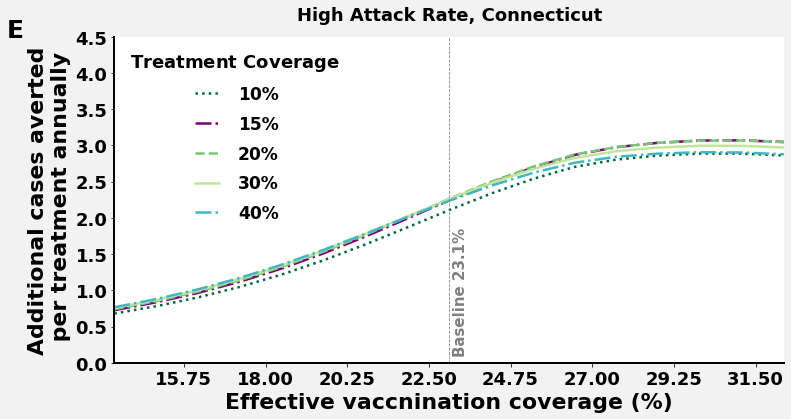

In [58]:
vacc_inc = np.arange(0.6,1.45,0.05)
treat_inc = [0.1,0.15,0.2,0.3,0.4]
res_high_ct = treatment_vaccination_relation_plot(fitted_params= ct_params_fitted, state= 'Connecticut', population= 3565287,
                                    vacc_increase_vals= vacc_inc, treatment_increase_vals= treat_inc, 
                                        seasons= [2018], avg_vacc_coverage= 51.24, ylim_min= 0.0, ylim_max= 4.5,
                                   plt_title= 'High Attack Rate, Connecticut',  panel= 'E', fntsize=16,median_ar=True)
res_high_ct[0].savefig(fig_loc.format('2-way analysis high CT'))

## Virginia

### Virginia data

In [59]:
# loading attack rate
attack_rate_mdl_va = pd.read_pickle('./model_data/VA_model_attackrate.pickle')
attack_rate_dt_va = pd.read_pickle('./model_data/VA_data_attackrate.pickle')

# loading proportion
proportion_mdl_va = pd.read_pickle('./model_data/VA_model_proportion.pickle')
proportion_dt_va = pd.read_pickle('./model_data/VA_data_proportion.pickle')

# loading fitted params
with open('./model_data/VA_fitted_parameters.pickle', 'rb') as pickle_in:
    va_params_fitted = pickle.load(pickle_in)
    
#loading vaccination coverage
with open('./model_data/va_vaccinatio_coverage.pickle', 'rb') as pickle_in:
    va_vacc_coverage = pickle.load(pickle_in)
    
# Loading calibrated results
va_calibrate_mdl = pd.read_pickle('./model_data/VA_mdl_fitting_res.pickle')
va_data = pd.read_pickle('./model_data/VA_data_fitting_res.pickle')

In [60]:
va_calibrate_mdl['total'].to_csv('VA fit results.csv')

### Plot calibration for Virginia

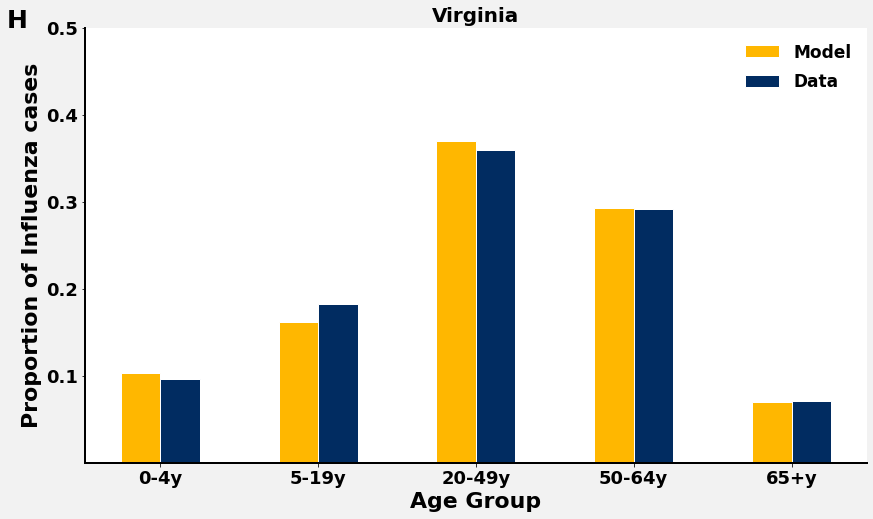

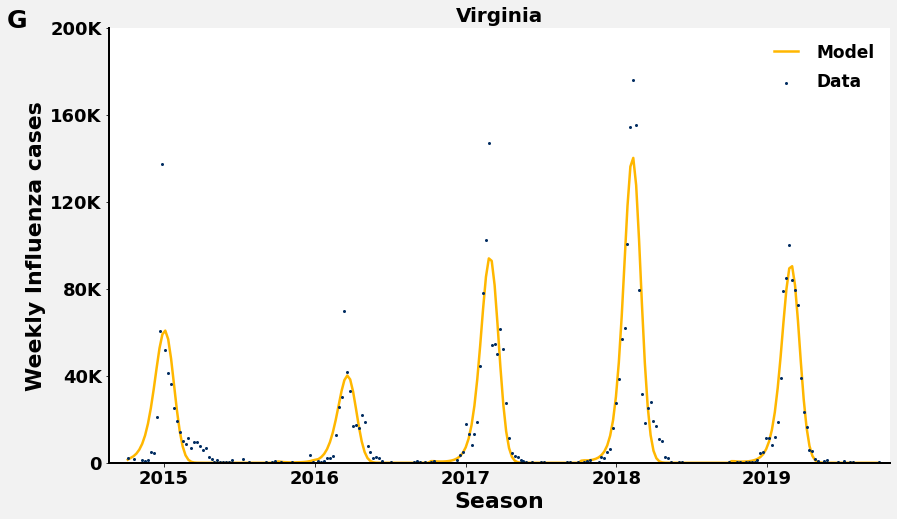

In [63]:
fig_cal1_va,ax_cal1_va = plot_calibration_age_group(proportion_mdl= proportion_mdl_va, proportion_dt= proportion_dt_va, state= 'Virginia', panel='H')
fig_cal2_va,ax_cal2_va = plot_calibration(calibrate_mdl= va_calibrate_mdl, state_data= va_data, population= 8535519, state= 'Virginia',
                ylim_max= 200000, panel='G', jump=40000)
fig_cal2_va.savefig(fig_loc.format('calibration_cases_VA'))
fig_cal1_va.savefig(fig_loc.format('calibration_proportion_VA'))

### plot of treated the baseline in 48 hours:

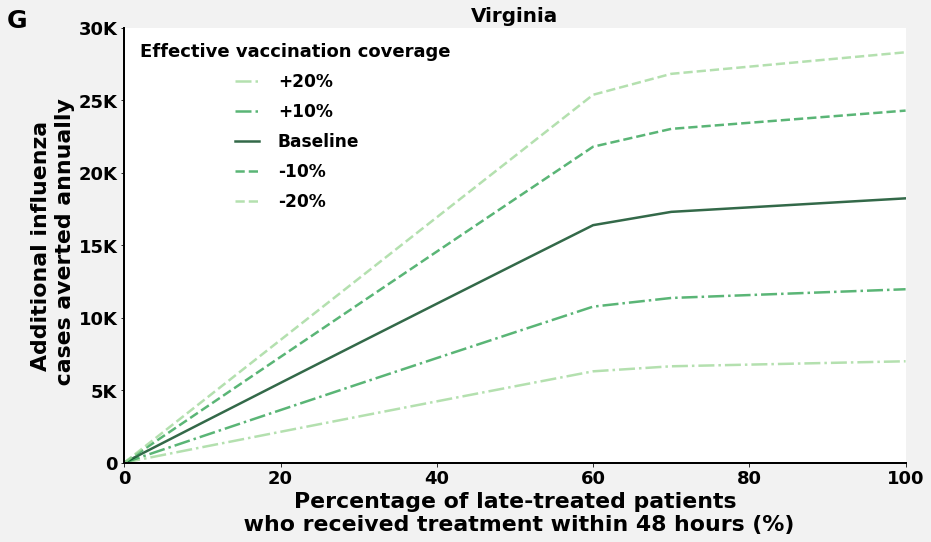

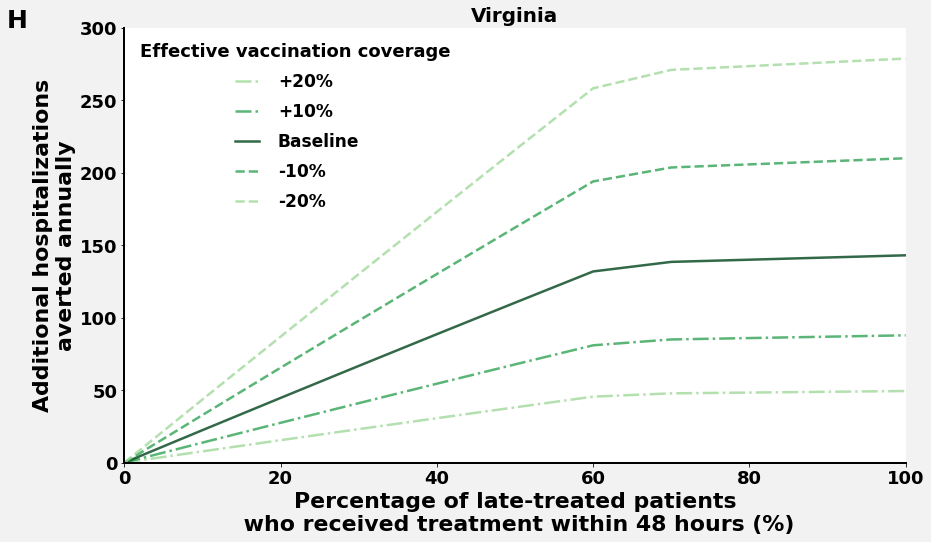

In [64]:
res_shift_va = shifting_tratments_plots(fitted_params= va_params_fitted,  state= 'Virginia', 
                         population= 8535519, ylim_max_cases= 30000, xlim_max_cases= 10500,title='Virginia', 
                         ylim_max_hosp= 300, xlim_max_hosp= 10500, fntsize=14, panel=['G','H'], jump=5000, jump_hosp=50)
res_shift_va[0].savefig(fig_loc.format('shift_cases_VA'))
res_shift_va[2].savefig(fig_loc.format('shift_hosp_VA'))

### Plot Averted with percent of treatment change

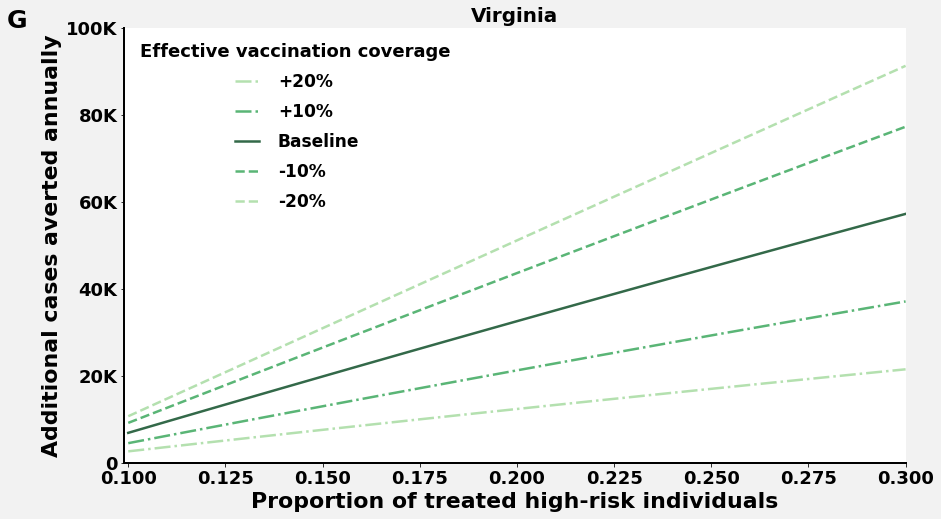

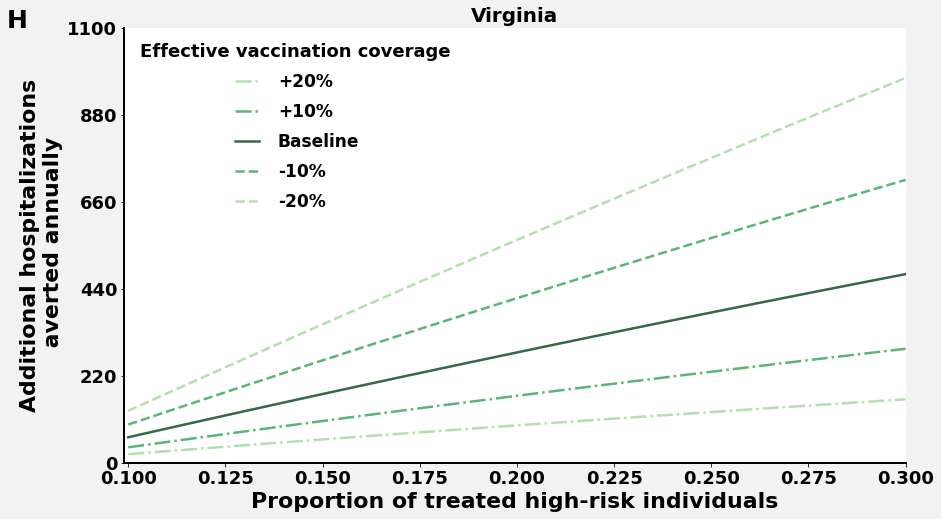

In [65]:
res_increase_va = increase_treatment_plots(va_params_fitted,'Virginia', 8535519, fntsize=14, panel=['G','H'],
                                          ylim_max_cases=100000, jump=20000, ylim_max_hosp=1100, jump_hosp=220, title='Virginia')
res_increase_va[0].savefig(fig_loc.format('increase_cases_VA'))
res_increase_va[2].savefig(fig_loc.format('increase_hosp_VA'))

### Plot Averted by age group

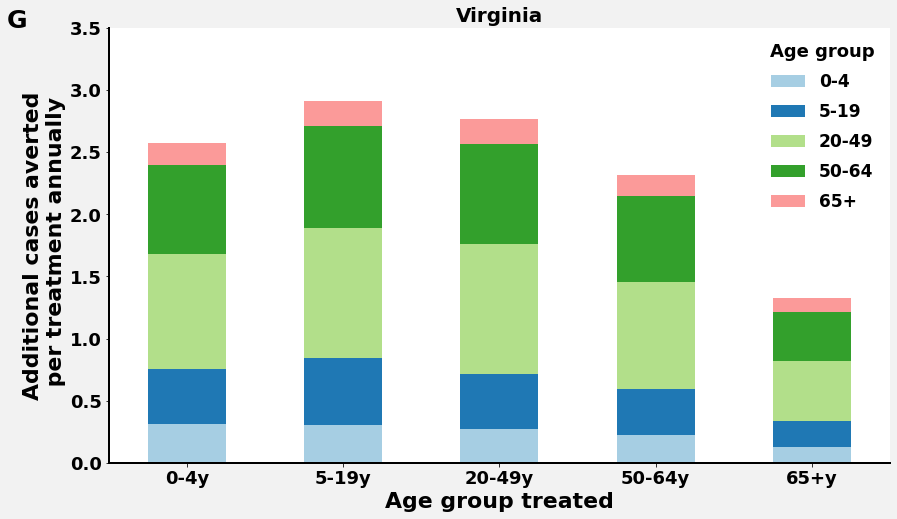

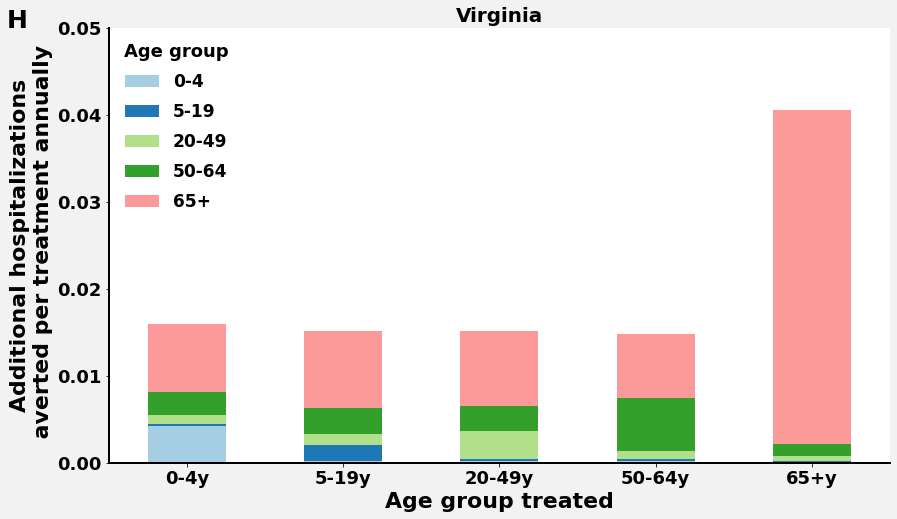

In [66]:
res_bars_va = pre_treatment_age_group_plots(fitted_params= va_params_fitted, state= 'Virginia', population= 8535519,
                             fntsize=14, panel=['G','H'], title='Virginia')
res_bars_va[0].savefig(fig_loc.format('bars_cases_VA'))
res_bars_va[2].savefig(fig_loc.format('bars_hosp_VA'))

### 2-way analysis

50.06
                                   season  baseline_cases  new_policy_cases  \
vacc_coverage percentage_increase                                             
0.6           0.10                 2017.0        0.200667          0.199420   
              0.15                 2017.0        0.200667          0.197060   
              0.20                 2017.0        0.200667          0.194680   
              0.30                 2017.0        0.200667          0.189862   
              0.40                 2017.0        0.200667          0.184970   
...                                   ...             ...               ...   
1.4           0.10                 2017.0        0.005231          0.005138   
              0.15                 2017.0        0.005231          0.004963   
              0.20                 2017.0        0.005231          0.004795   
              0.30                 2017.0        0.005231          0.004475   
              0.40                 2017.0     

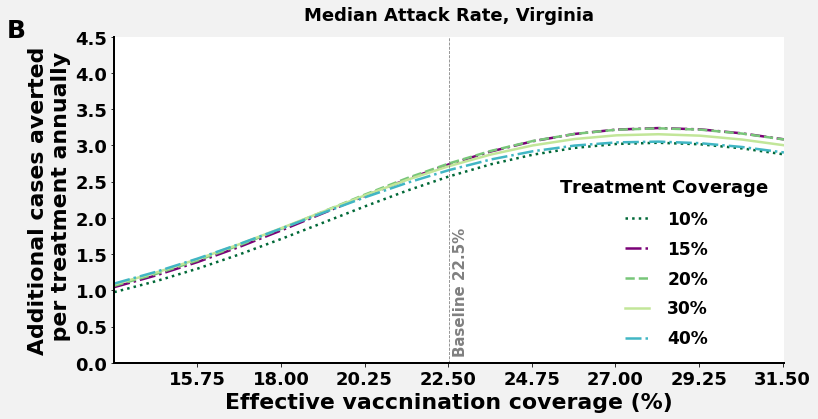

In [67]:
vacc_inc = np.arange(0.6,1.45,0.05)
treat_inc = [0.1,0.15,0.2,0.3,0.4]
res_med_va = treatment_vaccination_relation_plot(fitted_params= va_params_fitted, state= 'Virginia', population= 8535519,
                                    vacc_increase_vals= vacc_inc, treatment_increase_vals= treat_inc, 
                                        seasons= range(2015,2020), avg_vacc_coverage= 50.06, ylim_min= 0.0, ylim_max= 4.5,
                                   plt_title= 'Median Attack Rate, Virginia',  panel= 'B', fntsize=16,median_ar=True)
res_med_va[0].savefig(fig_loc.format('2-way analysis median VA'))

50.06
                                   season  baseline_cases  new_policy_cases  \
vacc_coverage percentage_increase                                             
0.6           0.10                 2016.0        0.169841          0.168158   
              0.15                 2016.0        0.169841          0.164960   
              0.20                 2016.0        0.169841          0.161741   
              0.30                 2016.0        0.169841          0.155246   
              0.40                 2016.0        0.169841          0.148686   
...                                   ...             ...               ...   
1.4           0.10                 2016.0        0.001001          0.000980   
              0.15                 2016.0        0.001001          0.000939   
              0.20                 2016.0        0.001001          0.000901   
              0.30                 2016.0        0.001001          0.000829   
              0.40                 2016.0     

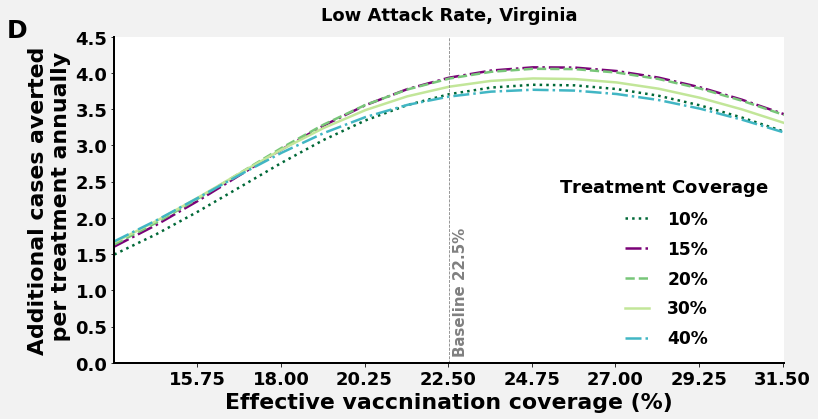

In [68]:
vacc_inc = np.arange(0.6,1.45,0.05)
treat_inc = [0.1,0.15,0.2,0.3,0.4]
res_low_va = treatment_vaccination_relation_plot(fitted_params= va_params_fitted, state= 'Virginia', population= 8535519,
                                    vacc_increase_vals= vacc_inc, treatment_increase_vals= treat_inc, 
                                        seasons= [2016], avg_vacc_coverage= 50.06, ylim_min= 0.0, ylim_max=4.5,
                                   plt_title = 'Low Attack Rate, Virginia', panel='D', fntsize=16,median_ar=True)
res_low_va[0].savefig(fig_loc.format('2-way analysis low VA'))

50.06
                                   season  baseline_cases  new_policy_cases  \
vacc_coverage percentage_increase                                             
0.6           0.10                 2018.0        0.243876          0.242894   
              0.15                 2018.0        0.243876          0.241034   
              0.20                 2018.0        0.243876          0.239154   
              0.30                 2018.0        0.243876          0.235333   
              0.40                 2018.0        0.243876          0.231429   
...                                   ...             ...               ...   
1.4           0.10                 2018.0        0.009747          0.009559   
              0.15                 2018.0        0.009747          0.009204   
              0.20                 2018.0        0.009747          0.008861   
              0.30                 2018.0        0.009747          0.008212   
              0.40                 2018.0     

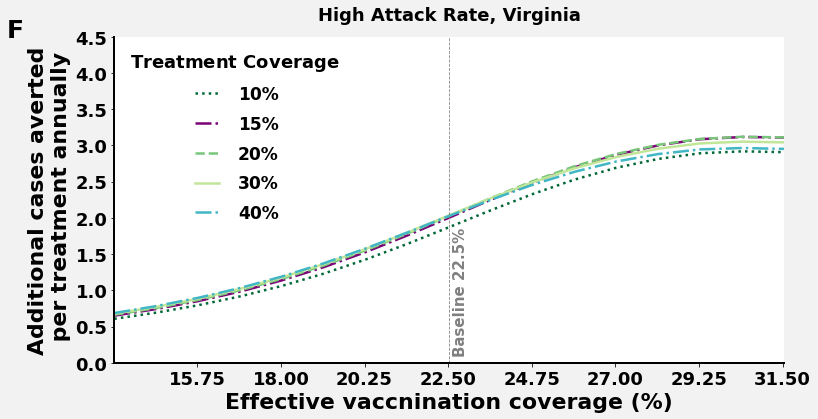

In [69]:
vacc_inc = np.arange(0.6,1.45,0.05)
treat_inc = [0.1,0.15,0.2,0.3,0.4]
res_high_va = treatment_vaccination_relation_plot(fitted_params= va_params_fitted, state= 'Virginia', population= 8535519,
                                    vacc_increase_vals= vacc_inc, treatment_increase_vals= treat_inc, 
                                        seasons= [2018], avg_vacc_coverage= 50.06, ylim_min= 0.0, ylim_max= 4.5,
                                   plt_title= 'High Attack Rate, Virginia',  panel= 'F', fntsize=16,median_ar=True)
res_high_va[0].savefig(fig_loc.format('2-way analysis high VA'))